In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scipy
import tqdm
warnings.filterwarnings('ignore')

import sklearn.linear_model as lm
import sklearn.ensemble as en

import torch
import os
import sys
sys.path.append(os.path.abspath('../python'))

import train_arvae
import verify_causal_model

# DGP + Synthetic Control

$y_i(0) = \mu_i \lambda_t + \delta_t + \epsilon_{i,t}$ \
$y_i(1) = \alpha_{i,t} + y_i(0)$

In [2]:
def gen_data( n_donor=10, T=20, T0=12, noise=1 ):
    lmbda = np.random.normal(0,1,size=(T,1))
    delta = np.random.normal(0,1,size=(T,1))
    mu = np.random.normal(0,1,size=(1+n_donor,1))
    epsilon = noise*np.random.normal(0,1,size=(T,1+n_donor))
    y0 = np.matmul(lmbda,mu.T) + np.matmul(delta,np.ones((1,1+n_donor))) + epsilon
    y1 = y0
    intervention = np.zeros((T,1+n_donor))
    intervention[T0:T,0] = 1
    y = intervention*y1 + (1-intervention)*y0
    return y,intervention,y1,y0

def synthetic_control( y, T0 ):
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    m_lasso = lm.LassoCV().fit(ypre_donors,ypre_target)
    y_target_lasso = m_lasso.predict(y_donors)
    effect = y_target - y_target_lasso
    return effect, y_target, y_target_lasso

In [62]:
n_donor=10 
T=30
T0=15
noise=1 
y,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=noise )

In [63]:
y_target = y[:,0]
y_donors = y[:,1:]
ypre_target = y[:T0,0]
ypre_donors = y[:T0,1:]

In [64]:
effect, y_target, y_target_lasso = synthetic_control( y, T0 )

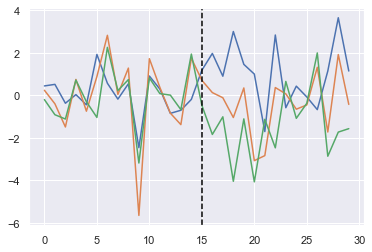

In [65]:
plt.plot(effect)
plt.plot(y_target)
plt.plot(y_target_lasso)
plt.axvline(T0,c='black',ls='--')

In [66]:
print(((np.mean(effect[:T0]),np.mean(effect[T0:]))))

(-2.2204460492503132e-17, 1.0422933175860036)


# Credence

## Training CREDENCE model

In [220]:
B = 10000
for i in range(B):
    y_,intervention_,y1_,y0_ = gen_data( n_donor=n_donor, T=T, T0=T0, noise=1 )
    y_donors_ = ( y_[:,1:] - np.mean(y_[:,1:]) ) / np.std(y_[:,1:])
    if i==0:
        data_ = y_donors_.reshape(T,1,n_donor)
    else:
        data_ = np.concatenate((data_,y_donors_.reshape(T,1,n_donor)),axis=1)
        
data_2d = train_arvae.convert_to_2d(data_)

In [221]:
print(f"Shape: {data_2d.shape}")
print(f"\nMean of raw data: {np.mean(data_2d):.3f}")
print(f"Std. dev of raw data: {np.std(data_2d):.3f}")

Shape: (10000, 300)

Mean of raw data: -0.000
Std. dev of raw data: 1.000


In [222]:
hyper_params = {}
hyper_params['epochs'] = 5000
hyper_params['latent_dim'] = 2 #Z
hyper_params['hidden_dims'] = [16,8]
hyper_params['kld_weight'] = 5e-8
vae_model, runner = train_arvae.train(data_2d, hyper_params, output_checkpoint_path='ar_vae_coverage_2d.ckpt')

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name          | Type       | Params
---------------------------------------------
0 | encoder       | Sequential | 5.0 K 
1 | fc_mu         | Linear     | 18    
2 | fc_var        | Linear     | 18    
3 | decoder_input | Linear     | 24    
4 | decoder       | Sequential | 144   
5 | final_layer   | Sequential | 5.1 K 
---------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)


Loss Before Training
{'loss': tensor(1.0471, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(1.0471, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(0.0462, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-10}


Validation sanity check: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0471), 'kld_loss': tensor(0.0462), 'reconstruction_loss': tensor(1.0471)}


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0381), 'kld_loss': tensor(0.0428), 'reconstruction_loss': tensor(1.0381)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0308), 'kld_loss': tensor(0.0386), 'reconstruction_loss': tensor(1.0308)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0253), 'kld_loss': tensor(0.0335), 'reconstruction_loss': tensor(1.0253)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0209), 'kld_loss': tensor(0.0277), 'reconstruction_loss': tensor(1.0209)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0177), 'kld_loss': tensor(0.0226), 'reconstruction_loss': tensor(1.0177)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0151), 'kld_loss': tensor(0.0215), 'reconstruction_loss': tensor(1.0151)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0128), 'kld_loss': tensor(0.0290), 'reconstruction_loss': tensor(1.0128)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0111), 'kld_loss': tensor(0.0520), 'reconstruction_loss': tensor(1.0111)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0094), 'kld_loss': tensor(0.0988), 'reconstruction_loss': tensor(1.0094)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0081), 'kld_loss': tensor(0.1786), 'reconstruction_loss': tensor(1.0081)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0069), 'kld_loss': tensor(0.3022), 'reconstruction_loss': tensor(1.0069)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0059), 'kld_loss': tensor(0.4793), 'reconstruction_loss': tensor(1.0059)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0047), 'kld_loss': tensor(0.7133), 'reconstruction_loss': tensor(1.0047)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0037), 'kld_loss': tensor(1.0038), 'reconstruction_loss': tensor(1.0037)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0027), 'kld_loss': tensor(1.3053), 'reconstruction_loss': tensor(1.0027)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0017), 'kld_loss': tensor(1.5722), 'reconstruction_loss': tensor(1.0017)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(1.0008), 'kld_loss': tensor(1.7830), 'reconstruction_loss': tensor(1.0008)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9999), 'kld_loss': tensor(1.9510), 'reconstruction_loss': tensor(0.9999)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9991), 'kld_loss': tensor(2.1050), 'reconstruction_loss': tensor(0.9991)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9983), 'kld_loss': tensor(2.2817), 'reconstruction_loss': tensor(0.9983)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9976), 'kld_loss': tensor(2.5138), 'reconstruction_loss': tensor(0.9976)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9970), 'kld_loss': tensor(2.8255), 'reconstruction_loss': tensor(0.9970)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9964), 'kld_loss': tensor(3.2177), 'reconstruction_loss': tensor(0.9964)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9958), 'kld_loss': tensor(3.6615), 'reconstruction_loss': tensor(0.9958)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9953), 'kld_loss': tensor(4.1071), 'reconstruction_loss': tensor(0.9953)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9947), 'kld_loss': tensor(4.5227), 'reconstruction_loss': tensor(0.9947)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9942), 'kld_loss': tensor(4.9009), 'reconstruction_loss': tensor(0.9942)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9937), 'kld_loss': tensor(5.2811), 'reconstruction_loss': tensor(0.9937)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9933), 'kld_loss': tensor(5.7202), 'reconstruction_loss': tensor(0.9933)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9929), 'kld_loss': tensor(6.2437), 'reconstruction_loss': tensor(0.9929)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9926), 'kld_loss': tensor(6.8566), 'reconstruction_loss': tensor(0.9926)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9922), 'kld_loss': tensor(7.5259), 'reconstruction_loss': tensor(0.9922)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9919), 'kld_loss': tensor(8.2395), 'reconstruction_loss': tensor(0.9919)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9916), 'kld_loss': tensor(9.0283), 'reconstruction_loss': tensor(0.9916)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9913), 'kld_loss': tensor(9.9295), 'reconstruction_loss': tensor(0.9913)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9912), 'kld_loss': tensor(10.9497), 'reconstruction_loss': tensor(0.9912)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9909), 'kld_loss': tensor(12.0486), 'reconstruction_loss': tensor(0.9909)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9906), 'kld_loss': tensor(13.1583), 'reconstruction_loss': tensor(0.9906)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9904), 'kld_loss': tensor(14.2431), 'reconstruction_loss': tensor(0.9904)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9902), 'kld_loss': tensor(15.3761), 'reconstruction_loss': tensor(0.9902)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9900), 'kld_loss': tensor(16.6852), 'reconstruction_loss': tensor(0.9900)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9898), 'kld_loss': tensor(18.2232), 'reconstruction_loss': tensor(0.9898)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9896), 'kld_loss': tensor(19.9128), 'reconstruction_loss': tensor(0.9896)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9894), 'kld_loss': tensor(21.6947), 'reconstruction_loss': tensor(0.9894)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9892), 'kld_loss': tensor(23.6119), 'reconstruction_loss': tensor(0.9892)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9891), 'kld_loss': tensor(25.6267), 'reconstruction_loss': tensor(0.9891)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9889), 'kld_loss': tensor(27.6158), 'reconstruction_loss': tensor(0.9889)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9888), 'kld_loss': tensor(29.5714), 'reconstruction_loss': tensor(0.9888)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9887), 'kld_loss': tensor(31.6725), 'reconstruction_loss': tensor(0.9887)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9885), 'kld_loss': tensor(33.9750), 'reconstruction_loss': tensor(0.9885)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9883), 'kld_loss': tensor(36.4149), 'reconstruction_loss': tensor(0.9883)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9882), 'kld_loss': tensor(38.9350), 'reconstruction_loss': tensor(0.9882)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9881), 'kld_loss': tensor(41.4205), 'reconstruction_loss': tensor(0.9881)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9880), 'kld_loss': tensor(43.8307), 'reconstruction_loss': tensor(0.9880)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9879), 'kld_loss': tensor(46.3506), 'reconstruction_loss': tensor(0.9879)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9878), 'kld_loss': tensor(48.8060), 'reconstruction_loss': tensor(0.9878)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9877), 'kld_loss': tensor(51.4787), 'reconstruction_loss': tensor(0.9877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9877), 'kld_loss': tensor(53.7866), 'reconstruction_loss': tensor(0.9877)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9875), 'kld_loss': tensor(56.4973), 'reconstruction_loss': tensor(0.9875)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9874), 'kld_loss': tensor(58.6477), 'reconstruction_loss': tensor(0.9874)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9873), 'kld_loss': tensor(61.3166), 'reconstruction_loss': tensor(0.9873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9873), 'kld_loss': tensor(63.7846), 'reconstruction_loss': tensor(0.9873)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(65.7792), 'reconstruction_loss': tensor(0.9872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9872), 'kld_loss': tensor(68.2694), 'reconstruction_loss': tensor(0.9872)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9871), 'kld_loss': tensor(70.0925), 'reconstruction_loss': tensor(0.9871)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(72.5465), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9870), 'kld_loss': tensor(74.8485), 'reconstruction_loss': tensor(0.9870)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(76.3934), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(78.6915), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9869), 'kld_loss': tensor(80.1422), 'reconstruction_loss': tensor(0.9869)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(82.4397), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9868), 'kld_loss': tensor(84.0558), 'reconstruction_loss': tensor(0.9868)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(85.6523), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(87.5717), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9867), 'kld_loss': tensor(88.9253), 'reconstruction_loss': tensor(0.9867)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(91.2749), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9866), 'kld_loss': tensor(92.1606), 'reconstruction_loss': tensor(0.9866)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(94.3644), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(95.3429), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9865), 'kld_loss': tensor(97.2031), 'reconstruction_loss': tensor(0.9865)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(98.9122), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(100.0754), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(102.3574), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(102.7945), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9864), 'kld_loss': tensor(105.2615), 'reconstruction_loss': tensor(0.9864)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(105.9095), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(107.3072), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(109.5151), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9863), 'kld_loss': tensor(109.4201), 'reconstruction_loss': tensor(0.9863)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(111.4854), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(112.3247), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9862), 'kld_loss': tensor(113.0818), 'reconstruction_loss': tensor(0.9862)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9861), 'kld_loss': tensor(115.2996), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9861), 'kld_loss': tensor(115.3061), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9861), 'kld_loss': tensor(116.4208), 'reconstruction_loss': tensor(0.9861)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(117.9449), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(118.3832), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(119.8917), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9860), 'kld_loss': tensor(120.8173), 'reconstruction_loss': tensor(0.9860)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(121.5331), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(123.0596), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9859), 'kld_loss': tensor(123.5849), 'reconstruction_loss': tensor(0.9859)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(124.8314), 'reconstruction_loss': tensor(0.9858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(126.1702), 'reconstruction_loss': tensor(0.9858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9858), 'kld_loss': tensor(126.8117), 'reconstruction_loss': tensor(0.9858)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9857), 'kld_loss': tensor(128.6079), 'reconstruction_loss': tensor(0.9857)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(128.8954), 'reconstruction_loss': tensor(0.9856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9856), 'kld_loss': tensor(130.1353), 'reconstruction_loss': tensor(0.9856)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9855), 'kld_loss': tensor(131.6163), 'reconstruction_loss': tensor(0.9855)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9854), 'kld_loss': tensor(133.0324), 'reconstruction_loss': tensor(0.9854)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9853), 'kld_loss': tensor(134.2010), 'reconstruction_loss': tensor(0.9853)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9852), 'kld_loss': tensor(134.9852), 'reconstruction_loss': tensor(0.9852)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9850), 'kld_loss': tensor(137.1001), 'reconstruction_loss': tensor(0.9850)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9849), 'kld_loss': tensor(137.9053), 'reconstruction_loss': tensor(0.9849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9849), 'kld_loss': tensor(140.8070), 'reconstruction_loss': tensor(0.9849)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9843), 'kld_loss': tensor(140.2122), 'reconstruction_loss': tensor(0.9843)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9839), 'kld_loss': tensor(140.7407), 'reconstruction_loss': tensor(0.9839)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9837), 'kld_loss': tensor(143.2274), 'reconstruction_loss': tensor(0.9837)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9830), 'kld_loss': tensor(144.2344), 'reconstruction_loss': tensor(0.9830)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9825), 'kld_loss': tensor(145.7333), 'reconstruction_loss': tensor(0.9825)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9822), 'kld_loss': tensor(147.0878), 'reconstruction_loss': tensor(0.9822)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9813), 'kld_loss': tensor(146.2220), 'reconstruction_loss': tensor(0.9813)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9810), 'kld_loss': tensor(145.6491), 'reconstruction_loss': tensor(0.9810)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9803), 'kld_loss': tensor(147.1751), 'reconstruction_loss': tensor(0.9803)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9796), 'kld_loss': tensor(148.8880), 'reconstruction_loss': tensor(0.9796)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9793), 'kld_loss': tensor(148.2743), 'reconstruction_loss': tensor(0.9793)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9784), 'kld_loss': tensor(145.0002), 'reconstruction_loss': tensor(0.9784)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9780), 'kld_loss': tensor(142.8023), 'reconstruction_loss': tensor(0.9780)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9773), 'kld_loss': tensor(142.8664), 'reconstruction_loss': tensor(0.9773)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9767), 'kld_loss': tensor(142.9488), 'reconstruction_loss': tensor(0.9767)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9764), 'kld_loss': tensor(141.4856), 'reconstruction_loss': tensor(0.9764)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9758), 'kld_loss': tensor(139.6888), 'reconstruction_loss': tensor(0.9758)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9756), 'kld_loss': tensor(138.6825), 'reconstruction_loss': tensor(0.9756)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9751), 'kld_loss': tensor(138.0332), 'reconstruction_loss': tensor(0.9751)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9749), 'kld_loss': tensor(138.2341), 'reconstruction_loss': tensor(0.9749)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9747), 'kld_loss': tensor(138.7838), 'reconstruction_loss': tensor(0.9747)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(138.8849), 'reconstruction_loss': tensor(0.9744)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9744), 'kld_loss': tensor(140.0412), 'reconstruction_loss': tensor(0.9744)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9742), 'kld_loss': tensor(141.1133), 'reconstruction_loss': tensor(0.9742)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9740), 'kld_loss': tensor(141.3408), 'reconstruction_loss': tensor(0.9740)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9739), 'kld_loss': tensor(143.2529), 'reconstruction_loss': tensor(0.9739)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9738), 'kld_loss': tensor(145.4619), 'reconstruction_loss': tensor(0.9738)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9737), 'kld_loss': tensor(146.4391), 'reconstruction_loss': tensor(0.9737)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9735), 'kld_loss': tensor(148.9699), 'reconstruction_loss': tensor(0.9735)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9734), 'kld_loss': tensor(152.1798), 'reconstruction_loss': tensor(0.9734)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(154.2461), 'reconstruction_loss': tensor(0.9733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9733), 'kld_loss': tensor(156.1522), 'reconstruction_loss': tensor(0.9733)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9731), 'kld_loss': tensor(158.5368), 'reconstruction_loss': tensor(0.9731)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9730), 'kld_loss': tensor(161.5260), 'reconstruction_loss': tensor(0.9730)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(163.5093), 'reconstruction_loss': tensor(0.9729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(165.7966), 'reconstruction_loss': tensor(0.9729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(168.6173), 'reconstruction_loss': tensor(0.9728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(170.3791), 'reconstruction_loss': tensor(0.9727)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(172.9716), 'reconstruction_loss': tensor(0.9728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(174.8195), 'reconstruction_loss': tensor(0.9728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9728), 'kld_loss': tensor(177.0580), 'reconstruction_loss': tensor(0.9728)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9729), 'kld_loss': tensor(176.8887), 'reconstruction_loss': tensor(0.9729)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9727), 'kld_loss': tensor(178.9938), 'reconstruction_loss': tensor(0.9727)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9724), 'kld_loss': tensor(179.4038), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9724), 'kld_loss': tensor(179.7449), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9725), 'kld_loss': tensor(181.1361), 'reconstruction_loss': tensor(0.9725)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9724), 'kld_loss': tensor(181.6726), 'reconstruction_loss': tensor(0.9724)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(182.6947), 'reconstruction_loss': tensor(0.9722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(183.0665), 'reconstruction_loss': tensor(0.9722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9722), 'kld_loss': tensor(183.2850), 'reconstruction_loss': tensor(0.9722)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9721), 'kld_loss': tensor(184.3036), 'reconstruction_loss': tensor(0.9721)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(184.1730), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(184.6119), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9720), 'kld_loss': tensor(186.1990), 'reconstruction_loss': tensor(0.9720)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9718), 'kld_loss': tensor(186.3383), 'reconstruction_loss': tensor(0.9718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9718), 'kld_loss': tensor(186.4339), 'reconstruction_loss': tensor(0.9718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9718), 'kld_loss': tensor(187.5423), 'reconstruction_loss': tensor(0.9718)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9717), 'kld_loss': tensor(187.9784), 'reconstruction_loss': tensor(0.9717)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(188.3134), 'reconstruction_loss': tensor(0.9716)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(188.8369), 'reconstruction_loss': tensor(0.9716)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9716), 'kld_loss': tensor(189.3855), 'reconstruction_loss': tensor(0.9716)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(190.3992), 'reconstruction_loss': tensor(0.9715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9715), 'kld_loss': tensor(190.7636), 'reconstruction_loss': tensor(0.9715)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9714), 'kld_loss': tensor(191.3502), 'reconstruction_loss': tensor(0.9714)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9714), 'kld_loss': tensor(192.5233), 'reconstruction_loss': tensor(0.9714)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(192.6061), 'reconstruction_loss': tensor(0.9713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(193.0284), 'reconstruction_loss': tensor(0.9713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9713), 'kld_loss': tensor(194.2443), 'reconstruction_loss': tensor(0.9713)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9712), 'kld_loss': tensor(194.6285), 'reconstruction_loss': tensor(0.9712)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(195.0992), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(196.0959), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9711), 'kld_loss': tensor(196.8578), 'reconstruction_loss': tensor(0.9711)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9710), 'kld_loss': tensor(197.5593), 'reconstruction_loss': tensor(0.9710)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(198.1132), 'reconstruction_loss': tensor(0.9709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9709), 'kld_loss': tensor(198.9323), 'reconstruction_loss': tensor(0.9709)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(199.7622), 'reconstruction_loss': tensor(0.9708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9708), 'kld_loss': tensor(200.2648), 'reconstruction_loss': tensor(0.9708)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(201.2724), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(202.1720), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9707), 'kld_loss': tensor(202.6499), 'reconstruction_loss': tensor(0.9707)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9706), 'kld_loss': tensor(203.7548), 'reconstruction_loss': tensor(0.9706)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(204.5851), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(205.2077), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9705), 'kld_loss': tensor(206.1768), 'reconstruction_loss': tensor(0.9705)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9704), 'kld_loss': tensor(207.0263), 'reconstruction_loss': tensor(0.9704)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(207.9472), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(208.7161), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9703), 'kld_loss': tensor(209.7321), 'reconstruction_loss': tensor(0.9703)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(210.6336), 'reconstruction_loss': tensor(0.9702)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9702), 'kld_loss': tensor(211.2664), 'reconstruction_loss': tensor(0.9702)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(212.3644), 'reconstruction_loss': tensor(0.9701)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9701), 'kld_loss': tensor(213.0316), 'reconstruction_loss': tensor(0.9701)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(213.8906), 'reconstruction_loss': tensor(0.9700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9700), 'kld_loss': tensor(214.7553), 'reconstruction_loss': tensor(0.9700)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9699), 'kld_loss': tensor(215.5179), 'reconstruction_loss': tensor(0.9699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9699), 'kld_loss': tensor(216.4315), 'reconstruction_loss': tensor(0.9699)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(217.2148), 'reconstruction_loss': tensor(0.9698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9698), 'kld_loss': tensor(218.1559), 'reconstruction_loss': tensor(0.9698)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(218.8105), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(219.7823), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(220.4753), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(221.4655), 'reconstruction_loss': tensor(0.9696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(222.1632), 'reconstruction_loss': tensor(0.9696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(223.1248), 'reconstruction_loss': tensor(0.9695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(223.7567), 'reconstruction_loss': tensor(0.9695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(224.9019), 'reconstruction_loss': tensor(0.9695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9694), 'kld_loss': tensor(225.2198), 'reconstruction_loss': tensor(0.9694)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9695), 'kld_loss': tensor(226.7066), 'reconstruction_loss': tensor(0.9695)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(226.2330), 'reconstruction_loss': tensor(0.9696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9697), 'kld_loss': tensor(227.5914), 'reconstruction_loss': tensor(0.9697)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9696), 'kld_loss': tensor(226.7085), 'reconstruction_loss': tensor(0.9696)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(226.7974), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(226.3514), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(226.6029), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9693), 'kld_loss': tensor(226.9693), 'reconstruction_loss': tensor(0.9693)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9692), 'kld_loss': tensor(225.9380), 'reconstruction_loss': tensor(0.9692)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(226.4767), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(225.8519), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(225.3504), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9691), 'kld_loss': tensor(226.9249), 'reconstruction_loss': tensor(0.9691)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(226.4087), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(225.3965), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(226.5522), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9690), 'kld_loss': tensor(226.3432), 'reconstruction_loss': tensor(0.9690)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(225.5139), 'reconstruction_loss': tensor(0.9688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9688), 'kld_loss': tensor(225.6556), 'reconstruction_loss': tensor(0.9688)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9689), 'kld_loss': tensor(226.0287), 'reconstruction_loss': tensor(0.9689)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(226.3739), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(225.5574), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(225.7007), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(227.0416), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(226.1739), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9687), 'kld_loss': tensor(225.1433), 'reconstruction_loss': tensor(0.9687)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9686), 'kld_loss': tensor(227.1317), 'reconstruction_loss': tensor(0.9686)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(227.6115), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(226.1369), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9685), 'kld_loss': tensor(226.4065), 'reconstruction_loss': tensor(0.9685)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(227.1156), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(227.1608), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(226.9890), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(226.9220), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(227.9416), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9682), 'kld_loss': tensor(227.8284), 'reconstruction_loss': tensor(0.9682)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9683), 'kld_loss': tensor(227.1664), 'reconstruction_loss': tensor(0.9683)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(228.6460), 'reconstruction_loss': tensor(0.9681)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(229.5071), 'reconstruction_loss': tensor(0.9681)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(228.6084), 'reconstruction_loss': tensor(0.9681)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9681), 'kld_loss': tensor(229.4263), 'reconstruction_loss': tensor(0.9681)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(230.2457), 'reconstruction_loss': tensor(0.9680)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(230.1283), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9680), 'kld_loss': tensor(230.1644), 'reconstruction_loss': tensor(0.9680)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(231.0618), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9679), 'kld_loss': tensor(231.6284), 'reconstruction_loss': tensor(0.9679)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(231.4673), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(232.2476), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9678), 'kld_loss': tensor(232.5827), 'reconstruction_loss': tensor(0.9678)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(233.4546), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(233.3484), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(234.4497), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(234.7938), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(234.8847), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(235.0983), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9677), 'kld_loss': tensor(236.7572), 'reconstruction_loss': tensor(0.9677)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(236.3852), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(236.3410), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(238.1194), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(237.9057), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(237.6741), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(239.0840), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9676), 'kld_loss': tensor(238.8875), 'reconstruction_loss': tensor(0.9676)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9675), 'kld_loss': tensor(239.5004), 'reconstruction_loss': tensor(0.9675)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(239.4347), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(239.2163), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9674), 'kld_loss': tensor(240.4823), 'reconstruction_loss': tensor(0.9674)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(240.2122), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(239.7650), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(240.8707), 'reconstruction_loss': tensor(0.9672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(241.3423), 'reconstruction_loss': tensor(0.9672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9673), 'kld_loss': tensor(241.6676), 'reconstruction_loss': tensor(0.9673)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9672), 'kld_loss': tensor(241.9025), 'reconstruction_loss': tensor(0.9672)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(242.7279), 'reconstruction_loss': tensor(0.9671)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9671), 'kld_loss': tensor(242.4787), 'reconstruction_loss': tensor(0.9671)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(243.3983), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(244.0784), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(244.2067), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(245.7611), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9670), 'kld_loss': tensor(245.7109), 'reconstruction_loss': tensor(0.9670)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(246.0998), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(246.5813), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(247.8562), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9669), 'kld_loss': tensor(247.8008), 'reconstruction_loss': tensor(0.9669)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(248.7379), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(249.0986), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9668), 'kld_loss': tensor(250.2767), 'reconstruction_loss': tensor(0.9668)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(250.4230), 'reconstruction_loss': tensor(0.9667)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(251.0746), 'reconstruction_loss': tensor(0.9667)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(251.6130), 'reconstruction_loss': tensor(0.9667)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9667), 'kld_loss': tensor(253.1092), 'reconstruction_loss': tensor(0.9667)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(253.1300), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(253.7673), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(254.4536), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(255.3443), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(255.4067), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9666), 'kld_loss': tensor(256.7455), 'reconstruction_loss': tensor(0.9666)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(257.1097), 'reconstruction_loss': tensor(0.9665)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(257.8317), 'reconstruction_loss': tensor(0.9665)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9665), 'kld_loss': tensor(258.2390), 'reconstruction_loss': tensor(0.9665)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(259.3172), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(259.4518), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(260.3876), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9664), 'kld_loss': tensor(260.6616), 'reconstruction_loss': tensor(0.9664)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(261.8131), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(262.1309), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(262.8763), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9663), 'kld_loss': tensor(263.2383), 'reconstruction_loss': tensor(0.9663)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(264.4773), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(264.7259), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9662), 'kld_loss': tensor(265.6120), 'reconstruction_loss': tensor(0.9662)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(266.1133), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(267.2105), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(267.5894), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(268.8183), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9661), 'kld_loss': tensor(269.3460), 'reconstruction_loss': tensor(0.9661)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(270.1580), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(270.4767), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(271.8943), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9660), 'kld_loss': tensor(272.2993), 'reconstruction_loss': tensor(0.9660)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(273.2924), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(274.0451), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(275.1389), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9659), 'kld_loss': tensor(275.1909), 'reconstruction_loss': tensor(0.9659)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(276.5005), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(277.1894), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(277.9034), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(278.6527), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(279.8860), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9658), 'kld_loss': tensor(279.8464), 'reconstruction_loss': tensor(0.9658)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(281.1268), 'reconstruction_loss': tensor(0.9657)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(281.9203), 'reconstruction_loss': tensor(0.9657)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(282.5634), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(283.2946), 'reconstruction_loss': tensor(0.9657)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9657), 'kld_loss': tensor(284.6512), 'reconstruction_loss': tensor(0.9657)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(284.7881), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(285.9114), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9656), 'kld_loss': tensor(286.6621), 'reconstruction_loss': tensor(0.9656)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(287.3493), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(287.8117), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(289.1046), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(289.2902), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(290.3907), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9655), 'kld_loss': tensor(291.1651), 'reconstruction_loss': tensor(0.9655)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(292.0386), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(292.3265), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9654), 'kld_loss': tensor(293.6541), 'reconstruction_loss': tensor(0.9654)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(293.9957), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(294.7456), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(295.5051), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(296.4038), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(296.5261), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9653), 'kld_loss': tensor(298.1461), 'reconstruction_loss': tensor(0.9653)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(298.5371), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(299.2378), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(300.2141), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(301.0706), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9652), 'kld_loss': tensor(301.2135), 'reconstruction_loss': tensor(0.9652)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(302.8594), 'reconstruction_loss': tensor(0.9651)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(303.0868), 'reconstruction_loss': tensor(0.9651)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9651), 'kld_loss': tensor(303.7126), 'reconstruction_loss': tensor(0.9651)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(304.7915), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(305.7178), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(306.0301), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(307.9182), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(308.1461), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(308.9818), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9650), 'kld_loss': tensor(310.1312), 'reconstruction_loss': tensor(0.9650)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(310.9578), 'reconstruction_loss': tensor(0.9649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(311.2067), 'reconstruction_loss': tensor(0.9649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9649), 'kld_loss': tensor(313.0755), 'reconstruction_loss': tensor(0.9649)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(313.3049), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(314.2968), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(315.4465), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(316.3377), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(316.6241), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9648), 'kld_loss': tensor(318.6578), 'reconstruction_loss': tensor(0.9648)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(318.8907), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(319.5896), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(320.7545), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(321.4980), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9647), 'kld_loss': tensor(321.6326), 'reconstruction_loss': tensor(0.9647)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(323.7613), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(323.9341), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(324.5847), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(325.6158), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(326.5316), 'reconstruction_loss': tensor(0.9645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9646), 'kld_loss': tensor(326.7715), 'reconstruction_loss': tensor(0.9646)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(328.6779), 'reconstruction_loss': tensor(0.9645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(328.6930), 'reconstruction_loss': tensor(0.9645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9645), 'kld_loss': tensor(329.1636), 'reconstruction_loss': tensor(0.9645)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(330.3442), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(331.4692), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(331.0345), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(332.6258), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9644), 'kld_loss': tensor(333.3075), 'reconstruction_loss': tensor(0.9644)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(333.8685), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(334.2124), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9643), 'kld_loss': tensor(335.3737), 'reconstruction_loss': tensor(0.9643)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(335.8145), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(336.6193), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(336.8408), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(337.6451), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(338.3267), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(339.8188), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(339.3552), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(340.1447), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9642), 'kld_loss': tensor(341.3901), 'reconstruction_loss': tensor(0.9642)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(342.2075), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(341.5444), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(342.8705), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(344.0470), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(344.2321), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(345.2878), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(344.8462), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(345.8866), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9641), 'kld_loss': tensor(346.8747), 'reconstruction_loss': tensor(0.9641)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(346.9488), 'reconstruction_loss': tensor(0.9639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(346.3426), 'reconstruction_loss': tensor(0.9639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(348.1929), 'reconstruction_loss': tensor(0.9638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9639), 'kld_loss': tensor(349.1967), 'reconstruction_loss': tensor(0.9639)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(348.4647), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9640), 'kld_loss': tensor(349.7719), 'reconstruction_loss': tensor(0.9640)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(349.1549), 'reconstruction_loss': tensor(0.9638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9638), 'kld_loss': tensor(349.6984), 'reconstruction_loss': tensor(0.9638)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(350.7025), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(351.0685), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(351.8480), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(352.8597), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(353.4901), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9637), 'kld_loss': tensor(352.6982), 'reconstruction_loss': tensor(0.9637)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(354.7234), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(355.0669), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(355.1855), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(356.6329), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(356.7166), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(357.2283), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9636), 'kld_loss': tensor(358.1314), 'reconstruction_loss': tensor(0.9636)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(359.1540), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9635), 'kld_loss': tensor(358.3800), 'reconstruction_loss': tensor(0.9635)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(360.2429), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(360.8053), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(360.9474), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(362.1963), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(362.2376), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(362.5366), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(363.5528), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(365.0249), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9634), 'kld_loss': tensor(363.9413), 'reconstruction_loss': tensor(0.9634)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9633), 'kld_loss': tensor(365.5428), 'reconstruction_loss': tensor(0.9633)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(366.0826), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(366.4476), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(367.0247), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(367.9024), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(368.0397), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(369.2808), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(369.8811), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(369.7335), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(371.5716), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(371.5139), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(372.6134), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(373.1130), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9632), 'kld_loss': tensor(374.4166), 'reconstruction_loss': tensor(0.9632)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(373.5652), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(375.2867), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(375.3629), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(375.3708), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(376.8226), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9630), 'kld_loss': tensor(376.1357), 'reconstruction_loss': tensor(0.9630)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(377.1145), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9631), 'kld_loss': tensor(377.0183), 'reconstruction_loss': tensor(0.9631)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(377.7328), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(377.3458), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(378.7925), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(379.2785), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(378.6477), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9629), 'kld_loss': tensor(380.2808), 'reconstruction_loss': tensor(0.9629)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9628), 'kld_loss': tensor(379.5413), 'reconstruction_loss': tensor(0.9628)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(380.0658), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(380.6943), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(381.2379), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(381.9099), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(382.5696), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(383.4465), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9627), 'kld_loss': tensor(382.8582), 'reconstruction_loss': tensor(0.9627)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(384.2710), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(384.4579), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(385.1383), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(385.7240), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(386.2112), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(386.7520), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(387.4334), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(388.2002), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(387.9744), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(389.6252), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9626), 'kld_loss': tensor(389.5389), 'reconstruction_loss': tensor(0.9626)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9625), 'kld_loss': tensor(390.4093), 'reconstruction_loss': tensor(0.9625)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(390.5166), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(391.6406), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(392.0058), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(392.8323), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(393.1907), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(393.0961), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(394.2507), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(394.1940), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9624), 'kld_loss': tensor(395.1360), 'reconstruction_loss': tensor(0.9624)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(395.1974), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(396.4576), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(396.1048), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(397.2583), 'reconstruction_loss': tensor(0.9623)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(396.9963), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(397.5345), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(397.6921), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(398.5439), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(399.2885), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(399.6978), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(399.2615), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(400.8260), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9623), 'kld_loss': tensor(400.4318), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(401.8461), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9622), 'kld_loss': tensor(400.9044), 'reconstruction_loss': tensor(0.9622)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(401.7403), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(401.8966), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(402.4430), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(402.1760), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(402.6335), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(403.4297), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(403.8009), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(403.9817), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(404.2903), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(405.4879), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(405.4325), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(406.4607), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9621), 'kld_loss': tensor(405.9441), 'reconstruction_loss': tensor(0.9621)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9620), 'kld_loss': tensor(407.2373), 'reconstruction_loss': tensor(0.9620)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(406.7751), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(407.5300), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(407.6686), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(408.4037), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(408.8199), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(408.8148), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(409.8800), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(409.6612), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9619), 'kld_loss': tensor(410.4709), 'reconstruction_loss': tensor(0.9619)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(410.1284), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(411.2595), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(411.3582), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(412.1720), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(412.1194), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(412.7741), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(413.6163), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(413.3124), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(414.4558), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(414.3185), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(415.4007), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(414.7743), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(415.6539), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(415.9230), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(416.5072), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(416.9037), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9618), 'kld_loss': tensor(416.8806), 'reconstruction_loss': tensor(0.9618)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(417.8961), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(417.7110), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(418.5153), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(418.4735), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(419.1217), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(419.6454), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(419.9579), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(419.9811), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9617), 'kld_loss': tensor(419.9456), 'reconstruction_loss': tensor(0.9617)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(420.9933), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(420.6901), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(421.7282), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(421.6916), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9616), 'kld_loss': tensor(422.3405), 'reconstruction_loss': tensor(0.9616)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(422.2664), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(422.7390), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(422.9782), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(423.5627), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(424.7112), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(423.7058), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(425.1043), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(424.6663), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(425.3573), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(424.9272), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(425.4731), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(425.3517), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(426.0555), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(426.2139), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(426.1334), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(427.2535), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(427.4076), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(427.7184), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(428.0906), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(428.9629), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9615), 'kld_loss': tensor(428.0645), 'reconstruction_loss': tensor(0.9615)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(429.4381), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(428.8462), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(429.3030), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(429.3359), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(429.7756), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(429.6378), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(430.0274), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(431.0793), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(430.1161), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9614), 'kld_loss': tensor(431.4744), 'reconstruction_loss': tensor(0.9614)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(430.6451), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(431.1898), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(431.2942), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(431.6937), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(431.6516), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(432.3503), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(432.7728), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(432.4501), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(433.4107), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(433.8742), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(433.3790), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(434.5975), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(434.4389), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(435.1465), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(435.2602), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(436.2837), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9613), 'kld_loss': tensor(435.5383), 'reconstruction_loss': tensor(0.9613)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(436.7278), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(436.1244), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(436.2905), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(436.9036), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(436.7597), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(436.8289), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(437.1654), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(437.5604), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(437.5038), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(438.0961), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(438.1306), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(438.3332), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(438.9027), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(438.5247), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(439.5578), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(438.8560), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(439.4882), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(438.8228), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(439.5988), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(439.2403), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(439.4497), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(440.1041), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(439.7320), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(440.4052), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(440.3642), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(440.9299), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(440.2245), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(441.0240), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(441.2247), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(441.1277), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(441.9069), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(441.8163), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(442.7935), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(442.7689), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(443.5259), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(442.8478), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(444.0724), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(443.3012), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(443.8706), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(444.2933), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(443.9272), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9611), 'kld_loss': tensor(443.9744), 'reconstruction_loss': tensor(0.9611)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9612), 'kld_loss': tensor(444.4894), 'reconstruction_loss': tensor(0.9612)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(444.2387), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(443.8553), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(444.6563), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(444.4029), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(443.8135), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(444.5119), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9610), 'kld_loss': tensor(444.0144), 'reconstruction_loss': tensor(0.9610)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(444.1050), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(444.2834), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(444.5750), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(445.2058), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(445.3600), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(445.5908), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(445.3818), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(446.2418), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(446.2348), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(446.2427), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(447.2375), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(447.5075), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(447.9362), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(447.8359), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(448.2608), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(448.3579), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(449.1576), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(449.4546), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(449.5388), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(450.8244), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(450.6141), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(450.2493), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(451.3949), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(451.5128), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(451.4148), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(452.2112), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(452.3928), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(451.9786), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(453.1330), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(452.9116), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(453.2997), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(454.1807), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(454.2072), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(454.4248), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(454.9142), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(455.3233), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(455.0962), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(456.3452), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9609), 'kld_loss': tensor(455.2443), 'reconstruction_loss': tensor(0.9609)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(455.8974), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(455.3826), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(455.3780), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(454.7262), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(455.0761), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(455.2003), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(454.5726), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(455.3885), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9608), 'kld_loss': tensor(454.6534), 'reconstruction_loss': tensor(0.9608)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(455.2867), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(454.7710), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(455.0477), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(454.7164), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(455.2815), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(455.2935), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(455.3134), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(456.1913), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(455.5827), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(456.3666), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(456.0560), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(456.5065), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(456.7659), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(457.0150), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(457.2574), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(457.3571), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(458.3738), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(458.0865), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(458.8867), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(458.7368), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(459.2379), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(458.8679), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(459.4557), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(459.6609), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(459.7937), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(460.3759), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(460.1068), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(460.9754), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9607), 'kld_loss': tensor(460.3741), 'reconstruction_loss': tensor(0.9607)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(460.4463), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(460.2354), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(460.4256), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(460.5929), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(460.3112), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(460.7890), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(459.7725), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(460.4702), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(459.8365), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(460.4668), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.0080), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(460.7462), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.1740), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.6569), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.2639), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.8668), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(462.2350), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(462.6227), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(461.8133), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(462.5113), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(462.2151), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(462.7042), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(463.1295), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(462.9019), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(463.6023), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(464.0919), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(463.9498), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(464.7010), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(465.3295), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(465.4306), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(466.0098), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(466.5605), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(467.1240), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(466.6657), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(467.2650), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(467.2832), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(467.8145), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(467.6459), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(467.4193), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(467.9458), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(468.2459), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(468.3212), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(468.6624), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(469.2799), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(469.4062), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(470.1756), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(469.7770), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(470.5369), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(469.7928), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(470.1728), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(470.1926), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(470.3231), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(470.4504), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(470.6670), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(471.1858), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(471.2691), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(472.2527), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(471.4093), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(472.1630), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(471.8608), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(471.9093), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(472.6421), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(472.3878), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(473.1357), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(473.7211), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(474.0468), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(474.1099), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(475.3557), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(474.5425), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(475.3432), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(475.5753), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(475.1617), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(475.9805), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(476.4656), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(476.1568), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(477.2531), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(477.5410), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(477.2573), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(478.0223), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(477.9193), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(478.0041), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(478.7239), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9606), 'kld_loss': tensor(477.9146), 'reconstruction_loss': tensor(0.9606)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(478.7647), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(477.5500), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(477.9804), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(477.3358), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(477.4532), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(477.5996), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(477.1731), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(477.7349), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(477.2841), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(477.5645), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(477.4482), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(478.0501), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(478.4314), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(478.7373), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(479.2239), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(479.3521), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(479.9622), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(480.1244), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(480.4164), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(481.1845), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(481.6308), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(481.8986), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(482.8821), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.4248), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.7654), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(484.1826), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(484.4859), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(484.7815), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(485.3724), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(485.6790), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(486.2310), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9605), 'kld_loss': tensor(485.8796), 'reconstruction_loss': tensor(0.9605)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9604), 'kld_loss': tensor(487.0208), 'reconstruction_loss': tensor(0.9604)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(484.8086), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9603), 'kld_loss': tensor(485.3448), 'reconstruction_loss': tensor(0.9603)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(484.8373), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.4066), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.8433), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(483.1339), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9602), 'kld_loss': tensor(482.6228), 'reconstruction_loss': tensor(0.9602)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(482.8487), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(482.8432), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(482.0237), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.0927), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(483.6097), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(482.2297), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(483.6867), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(483.4688), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(483.1903), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(484.4962), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(484.1848), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(485.0182), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(486.0908), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(485.7595), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(486.3156), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(487.6382), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(487.3422), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(488.1564), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(489.1264), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(488.8536), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(490.0525), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(490.2817), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(490.9024), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(492.0135), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(492.1476), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(492.8520), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(493.9883), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(494.1219), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(494.8506), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(495.8061), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(495.2277), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(496.6483), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(496.8268), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(496.7403), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(497.4793), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(497.4594), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(497.4738), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(498.5735), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(498.4506), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(498.6266), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(499.4403), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(499.3917), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(500.2007), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(500.4459), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(500.8843), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(500.1549), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(501.5974), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(501.1917), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(501.2529), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(502.1148), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(501.4891), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(502.5374), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(502.9777), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(503.1288), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(503.1598), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(504.1778), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(503.1724), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(504.1522), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(503.9791), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(503.2784), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(503.6808), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(503.5768), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(502.9413), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(503.8231), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(503.3636), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(503.2936), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(504.2949), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(503.8477), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(504.3145), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(505.1690), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(504.7982), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(505.5924), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(506.0434), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(505.7138), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(506.5861), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(506.9900), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(506.6435), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(507.4933), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(506.6715), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(506.6801), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(507.2892), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(506.4092), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(506.8463), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(507.6472), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(506.5951), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(507.6673), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(507.6694), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(507.2523), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(508.4025), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(508.1422), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(508.7391), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(509.8885), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(509.7073), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(510.4070), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(511.4305), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(511.2219), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(512.4137), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(513.1379), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(512.2347), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(513.7800), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(513.7935), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(513.9335), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(513.5892), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(514.2479), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(514.4010), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(514.6874), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(514.9567), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(515.6591), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(516.4430), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(516.3043), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(517.1083), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(517.6153), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(517.9841), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(517.0466), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(518.0208), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(517.7689), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(517.2225), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(517.6415), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(516.9365), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(517.5269), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(517.3542), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(516.9094), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(517.8314), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(517.7745), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(517.6406), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(518.6669), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(518.7714), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(518.8996), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(519.7236), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(520.0559), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(520.3424), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(520.7022), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(521.0216), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(521.0425), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(521.4231), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(519.7031), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(520.7760), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(520.5037), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(519.8700), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(520.1046), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(519.8206), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(520.1134), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(520.2965), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(520.2269), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(520.5706), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(521.5083), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(520.2642), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(520.7938), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(521.1395), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(520.6517), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(521.6957), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(521.6438), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(522.1759), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(522.8079), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(522.5980), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(524.1581), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(524.7442), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(524.1904), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(525.4989), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(525.6958), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(526.1644), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(524.9683), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(525.8374), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(526.6527), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(526.3076), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(526.7438), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(527.3443), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(527.7239), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(528.6276), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(529.0777), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(529.5032), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(530.5945), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(529.9246), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(530.9034), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(530.7696), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(530.9183), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(531.8434), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(531.6759), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(532.5582), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(533.2426), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(533.3098), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(534.6384), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(535.2200), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(535.0506), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(536.5992), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(535.9322), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(536.4379), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(535.5125), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(535.2973), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(535.1793), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(534.5706), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(534.3217), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(534.4761), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(534.4989), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9598), 'kld_loss': tensor(533.7943), 'reconstruction_loss': tensor(0.9598)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(534.3867), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(532.6210), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(533.3483), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(533.4708), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(532.8186), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(533.6140), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(533.4893), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(533.8994), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(533.2507), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(533.7679), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(534.2838), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(534.4724), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(533.9520), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(534.3845), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(534.7956), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(535.0402), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(535.6677), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(536.4635), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(536.9459), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(536.4034), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(537.2621), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(537.7647), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(538.2341), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(537.5930), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(538.3571), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(539.4113), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(539.2595), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(539.7887), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(540.6615), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(541.2316), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(541.3552), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(542.6782), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(542.0723), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(543.1168), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(543.4241), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(543.1061), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(544.6884), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(544.4493), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(544.9995), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(546.7609), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(546.6309), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(547.5601), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(548.6354), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(548.1808), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(549.7924), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(549.2757), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(549.6216), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(550.9678), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(550.5297), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(551.0242), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(552.5087), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(552.3420), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(553.4054), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(553.9155), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(554.1567), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(555.4441), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(555.5558), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(557.4650), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(557.8764), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(558.2020), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(559.4930), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(559.7625), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(561.5558), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(557.7191), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(559.8437), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(560.5822), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(558.8331), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(559.9970), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(559.4741), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(558.7977), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(560.3372), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(559.8599), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(559.1643), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(560.5016), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(559.1746), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(558.9130), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(559.0278), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(556.4617), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(554.4105), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(554.4642), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(552.0421), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(551.9547), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(550.9537), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(548.2345), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(548.4161), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(548.1525), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(546.1719), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(546.9662), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(547.7062), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(545.7458), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(547.4371), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(547.2770), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(546.3046), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(547.9939), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(547.5607), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(548.1824), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(549.7760), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(549.1263), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(549.5770), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(551.1119), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(550.8574), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(551.6149), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(552.9946), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(552.8124), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(554.3338), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(554.7288), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(555.5466), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(556.8801), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(557.1001), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(558.0674), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(559.4078), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(560.5494), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(558.0504), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(560.6746), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(561.0942), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(560.6267), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(562.5842), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(561.4145), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(562.5289), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(562.9634), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(563.2857), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(560.6512), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(562.3268), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(564.4801), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(560.1252), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(561.6108), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(560.3566), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(558.0970), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(560.7059), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(558.9469), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(558.0377), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(559.9542), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(559.3887), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(557.7964), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(560.0292), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(560.5632), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(558.7613), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(561.0412), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(560.3569), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(559.9457), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(562.2752), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(560.9155), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(561.3312), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(563.5076), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(562.3835), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(562.6453), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(564.7767), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(563.7196), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(565.1583), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(566.5795), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(565.9728), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(567.7566), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(568.3568), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(568.2720), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(569.5890), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(570.0381), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(570.1029), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(571.9841), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(571.0138), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(572.1646), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(573.5041), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(573.8109), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(572.7899), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(574.9122), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(575.0941), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(575.5764), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(577.1074), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(575.1106), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(576.7251), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(577.3629), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(577.7238), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(575.0653), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(576.5040), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(578.1760), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(575.8730), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(577.4988), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(573.8023), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(573.4718), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(575.3585), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(572.2361), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(572.3823), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(573.3890), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(572.0510), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(571.9177), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(573.4969), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(573.0747), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(572.6395), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(574.2794), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(573.3575), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(574.2396), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(575.7490), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(574.4380), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(575.4651), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(577.1462), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(576.2951), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(577.5655), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(578.4647), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(577.7590), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(579.7445), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(579.9768), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(578.9317), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(580.7988), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(580.2863), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(580.5136), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(581.5292), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(581.3328), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(582.1557), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(582.1877), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(582.5455), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(582.9821), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(583.5672), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(583.9772), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(584.5414), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(585.3121), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(586.2954), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(587.2547), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(586.6399), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(587.9827), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(588.4083), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(588.5669), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(589.5586), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(589.3095), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(590.3420), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(591.5245), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(591.2514), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(592.6290), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(592.5330), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(592.3264), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(593.5826), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(593.2952), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(593.8421), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(594.3831), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(594.6022), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(594.9784), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(594.0277), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(594.9804), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(591.3455), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(592.5883), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(593.7371), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9597), 'kld_loss': tensor(591.4863), 'reconstruction_loss': tensor(0.9597)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(593.1705), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(589.4341), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(588.8065), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(591.0096), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(588.1567), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(588.5914), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(589.9239), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(589.1844), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(587.5213), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(589.2570), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(590.9345), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(587.7224), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(589.9407), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(590.4618), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(588.8478), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(590.9382), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(590.0875), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(589.7186), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(590.6102), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(590.0451), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(590.6461), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(591.9792), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(591.8569), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(591.7437), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(593.1774), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(592.4656), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(593.4617), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(594.7694), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(594.0709), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(595.5627), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(596.4763), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(596.2764), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(598.3755), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(598.8534), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(597.8212), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(600.3799), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(600.1577), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(600.4615), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(602.1733), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(601.4978), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(602.2083), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(604.0229), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(604.7309), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(601.1262), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9593), 'kld_loss': tensor(603.9678), 'reconstruction_loss': tensor(0.9593)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9594), 'kld_loss': tensor(606.3010), 'reconstruction_loss': tensor(0.9594)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(601.0359), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(603.3723), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(603.6271), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(600.6340), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(601.4467), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(601.4126), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(601.3976), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(598.6512), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(600.1746), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(601.0250), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(597.9744), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(599.6298), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(599.0286), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(598.0344), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(598.6898), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(597.8788), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(597.6771), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(599.3143), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(598.0454), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(598.0826), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(599.0875), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(598.3542), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(599.3433), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(599.8772), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(599.5820), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(600.8014), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(602.2356), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(599.3235), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(602.0347), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(602.7205), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(600.9361), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(603.1791), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(603.1379), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(603.1325), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(604.1964), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(604.6293), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(603.7242), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(605.9305), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(606.4617), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(604.5375), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(606.9562), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(606.7846), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(606.2725), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(608.5281), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(607.8386), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(607.2230), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(610.4459), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(609.9561), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(608.7952), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(611.8622), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(610.8789), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(611.0585), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(613.1968), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(612.0320), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(612.4884), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(614.4844), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(613.1483), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(614.9777), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(616.0991), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(615.2113), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(617.3224), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(617.3204), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(617.5382), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(619.6639), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(618.6443), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(620.1047), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(620.5590), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9595), 'kld_loss': tensor(619.8197), 'reconstruction_loss': tensor(0.9595)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(620.0822), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9599), 'kld_loss': tensor(619.0193), 'reconstruction_loss': tensor(0.9599)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(616.5822), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(612.0453), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9600), 'kld_loss': tensor(611.7842), 'reconstruction_loss': tensor(0.9600)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9601), 'kld_loss': tensor(614.7288), 'reconstruction_loss': tensor(0.9601)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(605.7386), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(603.4346), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9596), 'kld_loss': tensor(606.2418), 'reconstruction_loss': tensor(0.9596)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(601.6159), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(598.9773), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(598.8187), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(597.4357), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(594.1844), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(595.3512), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(594.8172), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(591.9847), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(593.6406), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(592.8021), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(591.3682), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(592.3176), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(592.4548), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(590.7965), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(591.9623), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(593.1761), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(591.0432), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(592.5264), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(593.5168), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(592.1022), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(592.3323), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(594.0852), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(593.6414), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(593.5657), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(595.8676), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(595.0923), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(596.1240), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(597.6719), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(597.6498), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(597.1012), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(599.9959), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(599.5836), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(600.0201), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(601.6879), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(601.2079), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(602.6585), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(603.6434), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(603.5632), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(605.0059), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(606.2030), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(606.1407), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(607.1580), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(607.9604), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(609.0193), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(608.4354), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(610.1835), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(610.2154), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(611.4794), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(610.3494), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(610.9626), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(612.0883), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(611.9240), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(612.9118), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(613.1685), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(614.0641), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(614.5006), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(615.5430), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(614.2105), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(615.7553), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(616.7236), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(615.8815), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(617.3773), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(617.8851), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(618.1641), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(618.3311), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(618.9843), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(619.0948), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(620.6852), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(621.5735), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(620.3654), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(621.9927), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(623.5737), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(623.4208), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(623.4235), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(624.8779), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(625.2225), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(626.2902), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(627.4810), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(626.8672), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(628.2637), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(629.2739), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(629.3756), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(627.5604), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(629.9809), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(631.5405), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(628.2351), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(630.7540), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(631.4686), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(629.9855), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(632.4153), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(631.8590), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(630.6886), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(634.1111), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(634.7457), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(631.3617), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(633.5922), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(635.2709), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(633.3998), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(635.5043), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(635.5500), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(633.7984), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(636.0793), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(636.8655), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(634.4442), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(637.2031), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(637.4352), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(635.5504), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(637.4930), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(637.3751), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(636.7911), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(637.8765), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(639.2889), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(636.6074), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(639.5332), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(640.8305), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(637.7323), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(639.9845), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(640.6674), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(640.7344), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(637.6814), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(639.0790), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(641.5773), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9592), 'kld_loss': tensor(637.5723), 'reconstruction_loss': tensor(0.9592)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(638.9097), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(637.7090), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(635.9683), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(635.9385), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(636.1755), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(636.5306), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(632.2333), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(633.9462), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(635.8773), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(630.8503), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(631.4761), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(632.2834), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(630.1733), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(629.3704), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(630.3218), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(630.5722), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(626.7125), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(627.7661), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(629.5264), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(624.9980), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(623.4506), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9591), 'kld_loss': tensor(625.4280), 'reconstruction_loss': tensor(0.9591)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(623.3394), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(621.0534), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(622.7739), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(621.7917), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(619.4052), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(620.2227), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(619.7855), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(619.0947), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(619.0124), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(620.1963), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(619.1198), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(619.2302), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(621.4728), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(620.5828), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(620.2363), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(622.5375), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(623.2111), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(622.1396), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(624.5316), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(624.7324), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(624.8946), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(626.0444), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(626.8403), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(626.5874), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(629.1249), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(628.6657), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(629.3323), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(630.5983), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(631.9540), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(629.6698), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(632.0152), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(633.0884), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(632.3164), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(634.1916), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(634.4147), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(634.9583), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(635.6854), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(637.3215), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(635.5997), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(637.8442), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(638.5483), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(637.4711), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(639.6074), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(640.1257), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(640.3546), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(640.3574), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(641.7370), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(641.9788), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(643.1120), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(643.7604), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(643.4057), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(645.5025), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(646.0624), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(645.5036), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(647.0935), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(648.0922), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(648.2893), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(648.7196), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(649.9849), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(650.0303), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(651.1932), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(650.4316), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(651.0394), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(652.3132), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(652.1632), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(651.2889), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(652.7376), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(653.4028), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(652.7574), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(654.5605), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(653.9849), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(654.9718), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(654.4439), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(654.0165), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(654.0235), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(654.3433), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(655.1437), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(654.3465), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(655.3630), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(656.1565), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(656.8591), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(653.7169), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(655.6237), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(657.3972), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(654.4755), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(656.2266), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(655.8926), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(655.1954), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(653.2579), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(653.8907), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(656.3787), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(651.2600), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(651.8306), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(653.1041), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(650.2576), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(651.6102), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(652.3951), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(651.3735), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(648.1163), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(649.0365), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9590), 'kld_loss': tensor(652.9026), 'reconstruction_loss': tensor(0.9590)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(647.9773), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(646.0961), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(649.0688), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(647.8502), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(647.1854), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(646.8119), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(646.8879), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(646.0132), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(646.5666), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(648.4026), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(646.0041), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(646.5774), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(648.6708), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(647.4327), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(647.2856), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(649.0309), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(649.5546), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(647.8481), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(649.7440), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(651.1343), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(649.8992), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(651.2101), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(652.2974), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(651.6808), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(652.5616), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(654.2595), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(653.7618), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(654.5604), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(656.2737), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(656.5640), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(656.5217), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(658.2596), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(658.6373), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(659.2954), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(660.4978), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(660.9012), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(662.0466), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(663.0482), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(662.5650), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(664.2742), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(665.2126), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(665.8490), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(664.1497), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(666.4591), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(666.8262), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(666.6553), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(668.0915), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(667.5159), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(669.1650), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(666.7694), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(667.3909), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(668.3837), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(667.9688), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(668.8056), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(668.7491), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(668.3019), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(670.1473), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(671.7822), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(667.4638), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(669.1647), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(671.3364), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(669.4951), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(670.0059), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(671.2068), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(671.3881), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(667.6281), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(669.5083), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(671.5721), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(666.7484), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(667.9186), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(669.1708), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(667.9009), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(665.2137), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9588), 'kld_loss': tensor(665.8758), 'reconstruction_loss': tensor(0.9588)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9589), 'kld_loss': tensor(668.5980), 'reconstruction_loss': tensor(0.9589)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(662.8131), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(660.2765), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(662.9477), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(662.9959), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(660.3172), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(658.4293), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(658.8141), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(660.2189), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(657.4517), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(657.3470), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(658.9330), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(657.8654), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(657.7434), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(658.5947), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(658.9779), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(657.3623), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(658.9698), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(660.0281), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(657.8172), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(659.1426), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(659.7453), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(659.0035), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(659.4675), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(660.1769), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(659.2865), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(660.8838), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(661.6710), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(660.2235), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(662.6509), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(663.2318), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(662.7191), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(662.9396), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(665.0463), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(664.5362), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(665.6387), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(665.7745), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(667.4155), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(666.0948), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(667.9587), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(667.3945), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(668.1790), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(668.8785), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(669.1411), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(669.5952), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(671.1994), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(671.4167), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(671.5711), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(673.1021), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(673.2894), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(674.3025), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(674.3436), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(675.5997), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(674.2847), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(675.9749), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(676.5248), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(675.9965), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(677.4194), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(677.8590), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(678.3749), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(679.1439), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(680.2903), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(678.2016), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(680.7736), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(681.5628), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(679.7139), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(682.0884), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(681.7731), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(682.2054), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(681.7612), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(682.4335), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(682.6266), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(683.6288), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(683.7493), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(684.3099), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(684.9582), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(685.4254), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(687.0948), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(684.0673), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(685.9841), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(687.3131), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(685.5566), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(687.3555), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9586), 'kld_loss': tensor(687.2803), 'reconstruction_loss': tensor(0.9586)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(688.9495), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(683.9444), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(682.9542), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9585), 'kld_loss': tensor(686.7960), 'reconstruction_loss': tensor(0.9585)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9587), 'kld_loss': tensor(683.8962), 'reconstruction_loss': tensor(0.9587)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(684.8735), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(682.0235), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(680.2188), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(681.9688), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(680.4120), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(680.2878), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(679.9932), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(679.1552), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(679.5901), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(680.2178), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(680.0029), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(680.4028), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(681.1803), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(678.8361), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(680.6522), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(682.1176), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(680.7122), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(681.5784), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(681.7241), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(683.3060), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(681.3505), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(682.1951), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(683.1542), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(681.9305), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(684.0097), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(680.9717), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(681.1536), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(683.3248), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9584), 'kld_loss': tensor(681.6083), 'reconstruction_loss': tensor(0.9584)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(682.8068), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(680.0391), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(679.9188), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9582), 'kld_loss': tensor(681.9160), 'reconstruction_loss': tensor(0.9582)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(680.0358), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(680.7449), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(677.8234), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9581), 'kld_loss': tensor(677.7407), 'reconstruction_loss': tensor(0.9581)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9583), 'kld_loss': tensor(679.4481), 'reconstruction_loss': tensor(0.9583)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(676.3367), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(676.9531), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(676.4932), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(674.7786), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(676.4638), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(675.7890), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(674.9490), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(674.7429), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9579), 'kld_loss': tensor(674.4891), 'reconstruction_loss': tensor(0.9579)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(675.1190), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(674.2621), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(674.5486), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(674.5341), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(674.8315), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(675.7339), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(674.7681), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(675.0751), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(675.9415), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(675.6608), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(676.0955), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(676.6790), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(676.6375), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(677.0411), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(677.3661), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(678.0086), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(678.3785), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(679.0242), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(679.1178), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(680.2809), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(680.5025), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(681.4053), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(681.2485), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(682.8705), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(683.1141), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(682.8829), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(683.8455), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(684.8828), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(684.8321), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(685.2906), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(686.4519), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(686.7973), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(687.3024), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(688.2510), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(687.9991), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(688.4965), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(689.7080), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(689.3907), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(690.6128), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(690.9556), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(691.2489), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(691.8160), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(692.6168), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(693.3532), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(693.3387), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(694.0915), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(694.4269), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(694.1314), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(694.2918), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(695.2750), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(694.4128), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(695.2716), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(696.1691), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(695.8151), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(697.3409), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(696.7712), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(697.4360), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(698.1166), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(697.6968), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(698.3510), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(699.0479), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(699.5032), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(699.0904), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(700.4569), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(700.7783), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(700.9717), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(701.8432), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(702.4310), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(703.2435), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(701.5015), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(703.3905), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(704.0900), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(703.6021), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(705.0466), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(705.6885), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(706.4639), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(704.0886), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(705.6950), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(707.0555), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9580), 'kld_loss': tensor(706.3569), 'reconstruction_loss': tensor(0.9580)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(708.4654), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(705.0791), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(705.6378), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(707.8430), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(705.7850), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(705.8885), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(707.7885), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(707.8398), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(704.9718), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(703.9336), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(706.6622), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(705.5858), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(704.1683), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9576), 'kld_loss': tensor(705.6223), 'reconstruction_loss': tensor(0.9576)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(705.0722), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(704.6493), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(705.6082), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(704.6385), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(705.0283), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(705.9660), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(705.9019), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(705.4725), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(705.9326), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(706.5735), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(706.1276), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(707.0884), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(708.8603), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(708.4913), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(707.8314), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(709.4310), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(709.9609), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(709.5787), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(710.8700), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(711.5429), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(711.1398), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(711.5159), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(711.2700), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(711.4747), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(711.6976), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(711.2419), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(710.9086), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(711.5939), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(711.7823), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(710.4970), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(711.5569), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(712.3713), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(711.7614), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(712.4429), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(713.5626), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(713.9147), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(712.3170), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(713.8027), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(714.8021), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(714.0978), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(715.0435), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(715.6298), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(715.9563), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(716.1219), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(716.2809), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(714.8629), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(715.6336), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(716.5082), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(715.2456), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(715.8569), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(717.0666), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(716.2319), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(715.2579), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(716.3132), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(716.5602), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(715.6398), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(716.6558), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(716.5150), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(716.1274), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(717.5165), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(716.8020), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(718.0312), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(718.4590), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(718.9946), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(719.2283), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(719.0710), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(720.0711), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(719.0649), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(719.6332), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.5596), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(719.9158), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.7355), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(721.3282), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(721.0934), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.1202), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.6210), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(721.3058), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(721.6304), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(722.9019), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(721.7938), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(721.1062), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(722.3751), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(722.0499), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(722.3966), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(722.9626), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(722.6251), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(722.8313), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(720.8303), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.4548), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(721.6202), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(720.9080), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.2598), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(721.8938), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.0896), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(720.2659), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(720.9878), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(721.3803), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.9417), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.3846), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(721.1805), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(721.0711), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(721.8600), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.7787), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(719.9735), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(722.0822), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.8508), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(720.5464), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(721.3810), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(722.1095), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(722.3966), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(718.4902), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9575), 'kld_loss': tensor(718.7378), 'reconstruction_loss': tensor(0.9575)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9578), 'kld_loss': tensor(721.2197), 'reconstruction_loss': tensor(0.9578)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9577), 'kld_loss': tensor(717.8488), 'reconstruction_loss': tensor(0.9577)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(718.2290), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(716.8692), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(715.1822), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(716.0319), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9574), 'kld_loss': tensor(715.6092), 'reconstruction_loss': tensor(0.9574)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(714.3046), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(713.7839), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(713.9393), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(712.9925), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(713.2125), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(713.3011), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(712.7562), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(712.7698), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(712.8054), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(713.8631), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(713.1818), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(714.2108), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(714.1513), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(713.6265), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(714.9278), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(714.7288), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(715.1090), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(715.5829), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(715.9510), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(716.5524), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(717.0876), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(717.1569), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(718.1964), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(718.5366), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(718.7042), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(719.5582), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(720.5665), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(720.8918), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(720.0186), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(721.6610), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(722.0516), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(722.2142), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(722.8170), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(723.9786), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(724.5938), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(722.9232), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(724.8564), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(724.7683), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(724.9653), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(725.6863), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(725.6285), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(725.9534), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(726.4133), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(727.1568), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(725.5505), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(727.2023), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.4768), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(726.9673), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(727.8572), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(728.3269), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(728.7263), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(726.8989), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(728.7432), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(728.9816), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(729.0344), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(730.3510), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.7715), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.1210), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.6540), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(728.9254), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(729.0009), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9573), 'kld_loss': tensor(730.0644), 'reconstruction_loss': tensor(0.9573)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(730.3414), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(727.6108), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.6204), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(730.4109), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(727.9550), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.0538), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.3367), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(728.4512), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(727.5542), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(728.2929), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.5419), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(728.2493), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(728.5611), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(726.7410), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(728.0099), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(728.3380), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.0176), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(727.6808), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(727.9376), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.3914), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(727.6548), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(729.3150), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(728.7861), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(727.1519), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(729.6010), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(729.7401), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(728.2957), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(730.0790), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(730.0067), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(730.1064), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(730.8493), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(731.2198), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(731.3724), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(732.2512), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(732.6572), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(732.6173), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(733.6289), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(734.2487), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(733.8336), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(734.7496), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(735.3697), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(733.5017), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.3686), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.7537), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.2514), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.4215), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.2511), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.0134), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.1271), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(736.8627), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(736.3237), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(737.5029), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(735.4954), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(735.7150), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.7114), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.6542), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(734.6966), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.8347), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(737.2993), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(734.7248), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.8413), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(737.0048), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.5414), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(735.5027), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.4589), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.6156), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.4487), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(737.1102), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(735.8491), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(737.0154), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(736.1804), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.8192), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(736.2542), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(736.2501), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.6530), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(735.9337), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.4031), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(736.4393), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(736.8373), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.9267), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.6393), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(738.0185), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(738.4624), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(739.4747), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.5702), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(738.4665), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(740.1937), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(740.4733), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(740.7751), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(741.0431), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(742.3319), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(742.8130), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(740.7562), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(743.0871), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.4833), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(742.9036), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(743.4736), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(743.4151), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(743.9137), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(743.6167), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(744.5256), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(743.6132), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(744.6950), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.4318), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(742.1658), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(743.7656), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(742.5474), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(741.0581), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(743.3811), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(743.3860), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(741.0945), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(742.5403), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.1784), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(741.7177), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(740.6940), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(741.4180), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(740.8203), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(742.0153), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(742.8632), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(739.0864), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(741.7003), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(742.2014), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(739.7661), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(740.6108), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(741.4130), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(740.6564), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(738.0254), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(740.4846), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.8539), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(738.4274), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(739.8492), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(738.3253), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(738.6226), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(738.1719), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.7999), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(736.9944), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.6859), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(738.1807), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(737.1038), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(737.6972), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(738.9473), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(739.0558), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(736.9000), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.1890), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.4756), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(738.4226), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.7475), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.5904), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(739.7831), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(739.3010), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(740.3770), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(740.1286), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(740.9725), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(741.3779), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(741.1240), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.4158), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.4075), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(742.6836), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(742.4025), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(742.9136), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(743.0230), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(742.9559), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(744.0541), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(743.9351), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(744.8007), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(744.7655), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(745.6534), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(745.8663), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(746.5006), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.3048), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.4636), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(748.7386), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(749.0365), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(748.7708), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.5184), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.3939), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.0109), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.4514), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.1073), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.5726), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.2482), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.8176), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.3035), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.7693), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.0510), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(751.6505), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.6746), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(751.6356), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(752.5311), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.9579), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.9832), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(752.2490), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.3654), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.4837), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.0950), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(752.4584), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.5650), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.4822), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(751.3509), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.0775), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.7698), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(751.2551), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.6640), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.2330), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.9896), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.9666), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.0471), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.5306), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.1822), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(754.3874), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.0777), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(754.0255), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.7611), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.0383), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.2262), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.4277), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(755.9452), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(755.1323), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(756.5977), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(754.2042), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.2817), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(755.9996), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(756.1710), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.4827), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(751.1332), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(754.3200), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(752.5933), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(752.6801), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(750.7592), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.3212), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.6352), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.9353), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.1334), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.9845), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(750.1445), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(747.9014), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.0919), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.0087), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.9107), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.6074), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(748.8202), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(748.6545), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(748.9219), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.1713), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(747.5786), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.0907), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.0127), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.9492), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(748.2730), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(748.8844), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(748.7283), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.0119), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.8057), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.0613), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.7976), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.9185), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(751.1046), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.7818), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(751.8363), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(752.2988), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(751.3916), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.4240), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(753.1250), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.1607), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.2212), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(753.6773), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(753.3680), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.8239), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(754.5355), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(755.1442), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(756.2111), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(753.7203), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(754.8566), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.8233), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.2872), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(753.4977), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.5300), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(756.2465), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.3345), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(755.8293), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(754.8633), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(755.3060), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(753.1450), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.1673), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.1094), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.5896), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.0743), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.8085), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(751.8386), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(751.6901), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.3865), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.5231), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.4597), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.2529), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.6882), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.2691), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.7196), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.1188), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.6481), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.9313), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.1240), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.8883), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.9470), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.8461), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.3872), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.8640), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.6190), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.0761), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.2892), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.9082), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.7990), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(754.3873), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(754.1504), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(753.9883), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.3095), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.9031), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.3941), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.0770), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.5990), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.2526), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(757.2554), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(757.1942), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(757.9219), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(758.5881), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.8976), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.9743), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(758.0222), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(757.9047), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(757.9470), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(757.7775), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(758.0161), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(755.8323), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(757.3726), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.8046), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.0329), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.0280), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.3168), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(756.2445), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(755.1166), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(755.6689), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(755.7471), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.7850), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(754.2753), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.3384), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.0715), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.5638), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.0857), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.9797), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.8217), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(754.3803), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.9772), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.9979), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.3317), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.8687), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.5320), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(756.3560), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(757.5227), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.4433), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(755.4321), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.2945), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.5009), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.5081), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(758.2573), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(758.0306), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(757.8297), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.7275), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.0903), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.6939), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.7679), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.9759), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.1064), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.7848), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.4840), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.1962), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.7290), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.3622), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.8683), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.5041), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.0115), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.7722), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.3655), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.3920), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(758.3207), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.5568), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.6851), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.9193), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(760.1812), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(760.1426), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(756.5577), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.0306), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(759.7183), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(756.8334), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(758.4365), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9572), 'kld_loss': tensor(757.7103), 'reconstruction_loss': tensor(0.9572)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(757.8129), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(753.7678), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(754.7716), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(754.3253), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(753.4311), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9571), 'kld_loss': tensor(754.4498), 'reconstruction_loss': tensor(0.9571)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(750.3849), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(751.7015), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(751.4741), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.0674), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.5759), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.7625), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(750.0276), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.7916), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(748.6153), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.1277), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(748.3289), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(747.6512), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(748.5508), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(748.6531), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(747.9971), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.1700), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(748.2900), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.2595), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.3831), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.3193), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(749.5189), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.4255), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.1608), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(749.2501), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.6644), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.5900), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(750.9670), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(752.6974), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(752.8259), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.1641), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(752.1611), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(753.7081), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(753.7228), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.2167), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(754.8669), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(753.9938), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.3450), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(755.6366), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.6830), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(755.2236), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.0231), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.8289), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.3912), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.1570), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.6442), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.8363), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.5083), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.7890), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.2856), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.8281), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.4130), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(759.8494), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(760.2962), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.8367), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(760.4590), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(760.5109), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(761.0460), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.6723), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(760.6288), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(760.0981), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(760.1316), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(760.5129), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.0701), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.4750), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.0892), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.8627), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.4321), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.6816), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.7472), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.1156), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.9050), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.4067), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.7227), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.1135), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.0737), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.7258), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.6280), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.7916), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(758.5231), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(759.1745), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.6479), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.2075), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.7475), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.3345), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.4098), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.8903), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.8419), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.1218), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.0140), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.8310), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(759.3071), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.3466), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(759.5068), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.4363), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(760.1289), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(760.4382), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(760.3976), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(761.0861), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.9808), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(761.1368), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(761.7850), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(761.8314), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(761.7823), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(762.5857), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(763.4149), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(762.7825), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(764.2163), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(763.8433), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(764.7302), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(765.0737), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(765.2672), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(766.2676), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(766.6965), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(766.4205), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(766.9603), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(767.1652), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(767.3140), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(764.9879), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(767.0594), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(766.1841), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(765.7605), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(765.8464), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(764.7825), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(764.6774), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(763.2415), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(763.3477), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(762.4890), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(763.0103), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(762.1053), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(762.3653), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(762.7155), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(762.6404), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(762.7202), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(762.7556), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(763.5119), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(760.2668), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(762.2176), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(762.3118), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(760.8610), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(761.8547), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(761.3179), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(761.6287), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.1713), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.5892), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.5151), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.4376), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(759.1896), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(757.4100), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.1653), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.1105), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(756.9667), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(756.3580), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.3614), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.7618), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.7689), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.7746), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.5944), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.6027), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.6580), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.5469), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(756.9078), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.8901), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.9112), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.5397), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.4777), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.6852), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(757.3777), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(757.8094), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.5809), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.1748), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.4595), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.6049), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.7537), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(758.3057), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.8854), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.7228), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.3523), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.6138), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.8644), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.2440), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(757.9624), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(758.3613), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(758.6446), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(758.1927), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.9760), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(758.7255), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(758.4240), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(759.4968), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.3644), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(757.3597), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(758.5249), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(756.8852), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(756.0895), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(757.6407), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(757.3179), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.4890), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(756.7572), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.7170), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(756.0961), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(754.5256), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(755.3767), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(754.6935), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.1121), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.5601), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(752.6545), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(754.7910), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.7672), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(752.6764), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(753.5114), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(752.8520), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(752.9337), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(752.8275), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(753.3173), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.4439), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.3010), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(753.8409), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.4772), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(752.4291), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(753.2279), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(753.1640), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(753.0863), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(753.6251), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(753.5372), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(754.3039), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.9105), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(755.1793), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(755.5494), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(754.1865), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(755.2311), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.7272), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(755.9172), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(752.7381), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(754.3005), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(754.1779), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(752.5688), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(753.1143), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(751.8214), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(752.7938), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(752.2452), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(751.9978), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(751.9927), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(752.5649), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(753.0372), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(750.3780), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(751.6793), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(752.9028), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(752.3311), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(749.6425), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(751.3793), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(751.7646), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.2175), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(750.7880), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(749.5555), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9570), 'kld_loss': tensor(749.3500), 'reconstruction_loss': tensor(0.9570)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9569), 'kld_loss': tensor(746.5849), 'reconstruction_loss': tensor(0.9569)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(745.9188), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(744.2272), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(742.0056), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(741.4558), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(739.7974), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(739.5710), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(738.4803), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(737.3483), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(738.3309), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(737.0869), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(736.3057), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(735.9369), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.2313), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.0671), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(735.1690), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.6035), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(735.6503), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.4497), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.9926), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.3838), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(738.0119), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(737.2039), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(738.5004), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(738.4286), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(739.1874), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.7970), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(740.9237), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(741.5308), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(741.0531), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(742.0273), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(741.4211), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(742.0016), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.6034), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(740.4274), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(740.4390), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(740.3141), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(740.4308), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(740.5446), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(741.5228), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(737.6495), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.2640), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(739.3407), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(737.9532), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(738.2766), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(738.3925), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(738.1408), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(737.1224), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(737.9704), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(737.7354), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(737.2540), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.6680), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.2244), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(736.7264), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.8810), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.4531), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(736.9424), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(737.3212), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.8548), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(737.0491), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(737.4366), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(737.3973), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(737.0925), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(737.9263), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(737.7131), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(738.7308), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(738.7691), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(740.1586), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(740.6301), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(738.3058), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.3359), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(740.2588), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(739.8312), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(737.7432), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.7396), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(739.7872), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(739.0567), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(739.7836), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(740.0084), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(740.4306), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(736.4011), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(737.7643), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(737.8090), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(737.0618), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(737.2739), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(734.0621), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(734.2118), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(733.3300), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(732.4998), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(731.1456), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(731.4993), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(731.1700), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(730.4945), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(730.3815), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(729.7170), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(729.8967), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(728.9858), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(728.7847), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(729.4207), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(728.7894), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(729.5438), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(729.4528), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(729.8719), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(731.3297), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(730.5782), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(730.9844), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(731.0348), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(731.7336), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(731.1784), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(731.2742), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(731.6941), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(732.1014), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(731.9201), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(732.7809), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(733.1450), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(733.2962), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(733.5256), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(734.9006), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(734.5657), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(733.0291), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(734.2817), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(735.0453), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(734.7818), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(734.5371), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(736.2178), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(736.5890), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(733.2059), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(734.9181), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(735.2795), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(734.6584), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(734.5106), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9567), 'kld_loss': tensor(735.0320), 'reconstruction_loss': tensor(0.9567)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(735.2098), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(730.7799), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(732.3011), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(731.9039), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9568), 'kld_loss': tensor(731.4116), 'reconstruction_loss': tensor(0.9568)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(731.7161), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(726.9573), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(727.9833), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(727.1030), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(726.0632), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(724.6832), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(724.5829), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(724.9465), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(720.3807), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(722.1514), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.7255), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(719.3664), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(720.1068), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(717.3634), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(717.7680), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(716.9340), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.1156), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(716.5662), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(714.8882), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(716.2150), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.9147), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(714.0963), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(716.1985), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.5830), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(714.3290), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.6260), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(715.2507), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(715.6319), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.7309), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(714.9226), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.3630), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.6085), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.1941), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.5511), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.4045), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.1427), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(716.7001), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(716.0820), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(717.5916), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.4515), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.6879), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.4446), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.4396), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(717.5616), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.6826), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.0249), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.5223), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.9552), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.1458), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.5917), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.6041), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.6878), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.7272), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(718.0972), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(718.9132), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.1323), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.0754), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.0382), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.0438), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.3514), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.5579), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.1854), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.5778), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.8548), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.6312), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(721.4804), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.3687), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.7009), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.9230), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.7407), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.3209), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.5428), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.0511), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.2115), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.8450), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.0791), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.7444), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(718.9730), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(718.8369), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(718.9321), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.4648), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.4159), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.8664), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.9453), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.9040), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.8417), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.4381), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.2966), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.6435), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.7249), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.1539), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(717.9918), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.7213), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.5539), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.6111), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.3075), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.3167), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.9486), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.8586), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.5539), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.8098), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.5289), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.6374), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.0647), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.8228), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.3480), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.0234), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.6124), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.3199), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.3018), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.3024), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.1150), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.4039), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.6462), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.1027), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.5079), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.3349), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.4196), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(725.1688), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(725.7290), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.8962), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(725.4455), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.8583), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.1983), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(725.0687), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(725.8810), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(726.4528), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(723.4686), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.0178), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.2739), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.6099), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.6331), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(725.8433), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(726.0677), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(723.0837), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.1916), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.6391), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.5869), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(724.9202), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(724.6765), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(724.8505), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.7316), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.9653), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.8649), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(722.3384), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(722.3190), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(722.1467), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(722.1483), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.9315), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.2602), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(719.6560), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9566), 'kld_loss': tensor(718.9396), 'reconstruction_loss': tensor(0.9566)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(719.7754), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.6564), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.0425), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(716.5325), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(715.4834), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(715.4434), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(713.4500), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(713.5183), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(712.9022), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(712.2822), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(712.0717), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(712.2716), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(711.7924), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.0779), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.2200), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(710.8988), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.7386), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(711.1760), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(711.0374), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(711.1411), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.4976), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.2968), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.6359), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.2631), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.4074), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(713.1455), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(712.8780), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.2189), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.1761), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.3430), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.7300), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.3988), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.7345), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.2184), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.8266), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.5212), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.5304), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.2826), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.8333), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.5035), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.1437), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.8019), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.9256), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.5067), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.0037), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.8497), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.1244), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.1652), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.2601), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.2247), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.5585), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.8052), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.6145), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.4598), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.7709), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.8699), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.6178), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.8712), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(725.4269), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(725.3710), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(726.3901), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.7062), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(727.4473), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(727.7535), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.3770), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(727.2328), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(726.9548), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(726.9590), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(726.7779), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(728.1257), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(728.1962), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.2725), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(726.7258), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(726.9889), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(726.6726), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(725.6839), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(727.1979), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(727.5654), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(722.6790), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(724.9078), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(724.8199), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9565), 'kld_loss': tensor(723.4941), 'reconstruction_loss': tensor(0.9565)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9564), 'kld_loss': tensor(723.4263), 'reconstruction_loss': tensor(0.9564)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.0813), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.7864), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.1019), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.6144), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.2946), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(717.9250), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(718.0584), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.0872), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.4150), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.9685), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.3770), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.8392), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.1244), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.5704), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(715.9863), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(714.9883), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.2296), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.3459), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.3452), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.1358), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.4354), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(716.3881), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.7078), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.2870), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.9896), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.4510), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.5584), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.7859), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.2938), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.3895), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.4962), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.6055), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.2552), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.3284), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.1655), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.7723), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.0017), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.8102), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.8481), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.1954), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.0057), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.8245), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.9738), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4866), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7877), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.0556), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.6804), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.5697), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.0687), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.7874), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.0616), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.0165), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.1703), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.6412), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.7567), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.6636), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.4003), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.9471), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.7980), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.5724), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.6689), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.6896), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.2012), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.0430), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.8441), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.2476), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.7501), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.5824), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.1987), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.6274), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.5129), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.1230), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.3789), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.7217), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.4635), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.7183), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.2723), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.1367), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.2732), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.8795), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(725.0526), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.1522), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.9619), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.7115), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.3637), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.9005), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.8849), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.8704), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.7856), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.7809), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.5101), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.2710), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.6730), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(724.3550), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(723.6651), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(724.1874), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.0743), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.1620), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.3368), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.1439), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.2118), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.4825), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.3038), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.6777), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.8597), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.2145), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(722.4390), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.7339), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.6855), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.9816), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.4986), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.6194), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.2836), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(720.8738), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.7274), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.9312), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.2860), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.1443), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.3714), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.9141), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.9876), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.1605), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.3901), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.3644), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.1014), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.2203), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.1487), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.8447), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7247), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9166), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.3725), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.2321), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.6931), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.0425), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.4858), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.8418), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.7128), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.2454), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.9803), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.8555), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.1225), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.8199), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.7129), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.6102), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.1502), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.6165), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.5651), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.1132), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.4300), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.6384), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.4820), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.1218), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.0390), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.7944), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.7578), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.2741), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.3277), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5057), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.1421), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.5936), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.3355), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.9926), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.8860), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.8613), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.6151), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.0848), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.9285), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.1543), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.9360), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.1184), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.2866), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7891), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5184), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.6889), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.4332), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.5867), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.6873), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.9703), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.2908), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.8055), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.0939), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.3106), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.5241), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.4864), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.5781), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.1026), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.7441), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.5765), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.1525), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.7994), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(723.1735), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.2492), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.3563), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.0866), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.9808), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.2403), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.5660), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(722.5283), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.1267), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.3840), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.5255), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.0099), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.4337), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.5707), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.1916), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.7850), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.6275), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.8656), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.4998), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.8041), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.4385), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.7526), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.8501), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.0637), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.9507), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.2533), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.2211), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4870), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.0865), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7781), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.1043), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.8898), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.1047), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.5837), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.8643), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.4076), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.8937), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.9736), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.9043), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.3334), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.5644), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.3532), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7645), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9576), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.5216), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.1644), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.4120), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.6262), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.9537), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.1030), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9943), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.3084), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.4955), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.3622), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5648), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.1584), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.6259), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.5771), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.1005), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.8546), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.0365), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.9913), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.3936), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.2812), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.6461), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.9085), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.5394), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5469), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.0682), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.5144), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.6727), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(719.5255), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(720.4776), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.3259), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.9273), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.0550), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.8094), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.4954), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.4463), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.1048), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.9725), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.9108), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.4952), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.3551), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.3689), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.5013), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.9266), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.1974), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.7059), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.2037), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.5711), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.4922), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.9526), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.2722), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.5754), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.3955), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.0471), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.2352), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.5165), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.5743), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.9623), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.8484), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7643), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.0283), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.2333), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.4191), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.0369), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.8508), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.2560), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.3348), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.4277), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.9689), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(721.7319), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(722.7462), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.9355), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.4860), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.5199), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(724.0588), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.1149), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(724.4357), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.1575), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.7401), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.6624), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(724.6242), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(725.0106), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.3895), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.9482), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(723.7366), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(723.2599), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(723.7715), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(724.1664), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(723.9206), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.2573), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(723.6725), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(724.1556), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(723.6476), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.4219), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(722.8854), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.9210), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.6160), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(722.4935), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(723.6152), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.7233), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.9515), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.3118), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(722.3199), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(721.5795), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.5178), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.8619), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(721.7381), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.9631), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.6359), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.3167), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.8278), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.0507), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.9944), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.4932), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.7926), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.4146), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.2662), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.4719), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(722.6101), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.9299), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.4061), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(722.5899), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.4157), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(722.2457), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.7818), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(721.0687), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.3704), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.5781), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9554), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.5236), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.6951), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.4382), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.8370), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.9030), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.9469), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.3814), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.0286), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(716.2831), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.8685), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.0004), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.9166), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.4998), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.2377), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.5610), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.8086), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.0655), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.6907), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.2033), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.2548), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.4731), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(714.7015), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.2310), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.1591), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.0540), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.1105), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.7377), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.0637), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.2026), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.3585), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.7656), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.1976), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.2554), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.6233), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.9502), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.5420), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.0911), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.9039), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7880), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.7991), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7309), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.5988), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.6490), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.9683), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4042), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.4086), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.1442), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.2688), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(721.2450), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.6951), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(721.4679), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.5051), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.7507), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.7593), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.0920), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(720.5114), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.8261), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.1691), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.6437), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.7606), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.6922), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.1281), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.2825), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.6258), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.0234), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.0054), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.5915), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.8974), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.9141), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.0267), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.0060), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.2239), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.3941), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.0378), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.4664), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.5161), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.0989), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.8190), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9666), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4976), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.3462), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.0949), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.6026), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.7174), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5175), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.0802), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.3045), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5164), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4717), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.9459), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.2348), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.9481), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.8063), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.9152), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.0337), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.2275), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.8116), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.4954), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.1121), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.2316), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.1898), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.2013), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(718.6105), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.0903), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.2252), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.3646), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.6738), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.9150), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.4539), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.8080), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.4750), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(721.2593), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.1020), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(720.4475), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(720.5432), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.3231), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.9606), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4751), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(720.5389), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.3491), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(720.7112), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.9592), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.2742), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.6281), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.2988), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.5024), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.2830), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.1436), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5339), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.4904), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.5414), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.6100), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.5163), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.2083), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.2645), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.9136), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.3291), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.2366), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.6714), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.0129), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.6248), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.6296), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.5829), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.0255), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4111), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.0521), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.9360), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.2380), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.7396), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(719.7405), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.4334), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.1369), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.0875), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.4367), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.9849), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.4248), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.3885), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.2828), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.9410), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.5924), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(719.5294), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.6667), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(719.4823), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.4734), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(720.0244), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(719.9061), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.9935), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(719.6468), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.8572), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(718.6682), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(718.1746), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(718.5744), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.6828), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.9876), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(718.5940), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(718.8074), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(718.3868), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.7006), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(717.4207), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(717.0454), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.2871), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.3060), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.3854), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.2217), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.1033), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.7416), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(716.5056), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(716.1163), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.3157), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.9274), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.0729), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.1155), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.3483), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.8162), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(716.1535), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(715.9075), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.3912), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.8438), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.0543), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.9781), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.2699), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.5396), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(715.5432), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.2944), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.9744), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.3243), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.6076), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.0451), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.0726), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.5505), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.6055), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(716.2239), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.6392), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(716.6224), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(717.6908), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.8031), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.0878), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(717.6843), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.4617), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(718.1407), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.5020), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(718.3218), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.8675), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(717.8938), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(717.0609), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(716.5151), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(715.8945), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9561), 'kld_loss': tensor(714.3471), 'reconstruction_loss': tensor(0.9561)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(713.8364), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.7938), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.7047), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.6936), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.2182), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.4401), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.7151), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(708.2836), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(706.4222), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(707.3184), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.1963), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.7834), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.1490), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(704.9733), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(706.3482), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.1942), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.6356), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1363), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.9948), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.3062), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.7144), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.1024), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.4509), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.7297), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.6005), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.2953), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.3945), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.5892), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.4233), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.3418), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.6821), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.2426), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.2155), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.2019), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.7530), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.3112), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.9751), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.7838), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.5490), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.2742), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(714.0740), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.8405), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.6406), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.3572), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.7353), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.1765), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.5146), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.6439), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.3243), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.0992), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.5476), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.6983), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(714.3057), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.7874), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.6431), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.0565), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.7640), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.2303), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.0814), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(715.7717), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.9501), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(714.1293), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.7042), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.4061), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.6543), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.2481), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(715.5842), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(714.7921), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.0155), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.9158), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.1046), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(715.1594), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.2705), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.3344), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.8738), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.7797), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.7833), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.4615), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.8359), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.0159), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.7175), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.2566), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(714.2032), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(714.0688), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.2117), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(714.5011), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.9344), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.3353), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.0446), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.3203), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.6976), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.9004), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.8354), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.1537), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.0528), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.4917), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.2869), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.1403), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(713.1769), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(713.6810), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.1307), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.0829), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.0881), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.6719), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.5473), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.8682), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.6460), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.9656), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.4565), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.2725), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.9751), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.1756), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.0623), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.8946), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.0557), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.4474), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.6932), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.0352), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.8670), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.9230), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.4047), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.7793), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.5494), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.6697), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.2817), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.3555), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.0657), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.5344), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.9476), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.4750), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.1228), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.0816), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.3869), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.4835), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.6953), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.4513), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.7804), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.7414), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.8165), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.6346), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.6385), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.6543), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.6182), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.3842), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.7218), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.8576), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.8528), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(713.3727), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(713.7694), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(714.3170), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.6865), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.2836), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(714.6819), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(715.8436), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.1708), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.7720), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(717.3426), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(716.0016), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(717.6037), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(716.5632), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.5613), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(716.3502), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.3121), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.8284), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(715.0311), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(716.2881), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(714.9775), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(715.9005), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.6898), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.3404), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.9097), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.9334), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.9342), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.2162), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.0358), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.1464), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.5391), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.5143), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(713.3555), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.5676), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.5609), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.1404), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.1207), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(713.0242), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.6695), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.2991), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.5414), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.4728), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.3587), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(714.3903), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.1353), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.0410), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(713.2006), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(712.5637), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.0599), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.9559), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.3345), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.7482), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.9866), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.6675), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.9282), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.5524), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.9253), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.5311), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.9362), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.1667), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.9724), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.3927), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.4371), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.7675), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.3391), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(713.1924), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(713.8732), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.2518), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(714.8854), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(713.4731), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(713.2803), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(714.0583), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9563), 'kld_loss': tensor(710.4817), 'reconstruction_loss': tensor(0.9563)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9562), 'kld_loss': tensor(711.2054), 'reconstruction_loss': tensor(0.9562)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(709.1581), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.8643), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.8225), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.4965), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.8088), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.6146), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.0001), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.8135), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.4039), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.0487), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(702.9495), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(702.3527), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(703.2205), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(702.5416), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(701.0717), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.9152), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.2973), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.6359), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.3967), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(701.5204), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.9283), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(702.0594), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(701.1675), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(701.6632), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.8698), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.5162), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.3483), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.7303), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.2510), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.4939), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(702.7546), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.3984), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.8347), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.1890), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.7321), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.8958), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.8698), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.3361), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.4415), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.4208), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.3787), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.4523), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.9719), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.1371), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2642), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.4356), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.7136), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.5665), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.2543), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.6728), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.2064), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.4153), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.8571), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.1327), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(709.9603), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.7859), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.3883), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.8983), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.2049), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.7738), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.8967), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.3149), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.6329), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.4510), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.3683), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.1847), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.8261), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(712.1129), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(710.4224), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.6547), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.1250), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.9581), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.3525), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.8035), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.9813), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.5143), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(710.7743), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.6340), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.2872), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(710.9341), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.3284), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.1973), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(710.5079), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(709.6661), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.8181), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(710.1073), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(710.3050), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(710.4359), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.4681), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.5148), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(709.3588), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.8480), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.7358), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.8696), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.5851), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.5679), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.2841), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.1896), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.3867), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.5903), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.9974), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(709.2020), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.7404), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.3143), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.5829), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.1034), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(710.3295), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.4755), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.4020), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(710.4301), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(710.0523), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(710.8898), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(710.6010), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.7612), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.3690), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.9391), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.7506), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.1113), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.5214), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(711.5676), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(711.6416), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(711.3950), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.3588), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.6220), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(713.1627), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.9952), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.9756), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(712.6857), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(711.6563), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(712.6867), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(711.8158), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(712.8854), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.7932), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(713.0026), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(711.7829), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(712.4506), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(711.6666), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.7526), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(711.3708), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(710.3874), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(711.3079), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(709.7689), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(709.8068), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.6044), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.5731), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.4731), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.0699), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.3621), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.4971), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.8301), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.9546), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.1976), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.1158), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.5535), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.0349), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.7178), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.5057), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.4193), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.4719), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.0920), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.6302), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.6746), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(708.2690), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(707.1835), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(708.0599), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.8275), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1639), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.8240), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.7531), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.4576), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.3295), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(707.8505), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.9520), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.3557), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.8182), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.7694), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.1161), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.4993), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(706.7566), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.0359), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.0309), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.1728), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.6374), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.2709), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.7885), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.1563), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.3389), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.9766), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.0659), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(704.5530), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.0034), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.0729), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.5020), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.4069), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.2104), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.8965), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.0209), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.9914), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.5859), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2613), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.0071), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.8752), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.1656), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.7806), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.1794), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.5367), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.5150), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.4556), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.1514), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.2009), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.8634), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.1797), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.8378), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.7626), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.4493), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.5541), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(710.3272), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.7228), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.8271), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.2609), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.5002), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.5247), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.6309), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.3900), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.7736), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(709.6181), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.9674), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(709.6351), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(709.3392), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(710.2153), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.4223), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(710.8830), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(710.0407), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(709.7465), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(710.3116), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(708.2638), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.4579), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.2026), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.7618), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.5662), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.9195), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.0188), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(704.7611), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1235), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.8278), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.7819), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.7415), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.9737), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.9276), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.3054), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.9112), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.7059), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.7081), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.1160), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.8099), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.0579), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.7732), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.1865), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.0680), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(704.9706), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(705.0861), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.2648), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.0582), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.2164), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.8845), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.1930), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.3311), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.5797), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.9790), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.4486), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.1021), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.2368), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.1307), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.5984), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.9633), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.5011), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.5396), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.4209), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.7772), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.6211), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.5255), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2859), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.7344), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.9338), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(706.4119), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.3845), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.7273), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.0518), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.8417), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(709.0879), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.5104), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.3644), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.4152), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.5911), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.3804), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.3661), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.4922), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.0756), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.1420), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.6053), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.5660), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.6165), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.9467), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.6406), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.8783), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(707.4122), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(707.6843), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.8262), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.4669), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.7992), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.4630), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.3333), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.2736), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.8900), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.6889), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.7068), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.5118), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.6504), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.6171), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(708.7182), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.8295), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(708.9368), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(708.3608), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(709.0372), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(708.5422), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(707.9322), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(708.7103), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.5493), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.6517), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.6160), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.3334), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.0413), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.6149), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1459), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.3168), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.4650), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(705.8229), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.3666), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.4687), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.5484), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.4672), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.0245), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.6902), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(704.8840), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.3762), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.6550), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.0447), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1339), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.9920), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.5490), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.6389), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.9764), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.9616), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1782), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.3661), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.5261), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.9908), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.4537), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.7230), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(706.3804), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.5165), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.8359), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.1811), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.6440), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.9248), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.1394), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.0591), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.0853), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.8268), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.5226), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.8437), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.4610), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.9973), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.7123), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.5494), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.8464), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(707.5331), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.9912), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(707.0849), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(709.4338), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(707.4747), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(708.9282), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(708.1008), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.1269), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.9578), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.5809), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(707.4047), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.1825), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(707.6608), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.9952), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.7749), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.0992), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(706.2048), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.4016), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.1675), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.6036), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(705.1948), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2311), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(705.6556), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(706.1193), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2343), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.5165), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.3478), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(707.6849), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(707.0678), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9560), 'kld_loss': tensor(707.1575), 'reconstruction_loss': tensor(0.9560)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(707.2985), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(706.4279), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(706.6581), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(705.2075), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(706.2330), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(705.6281), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(705.5848), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(705.3412), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(704.5545), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.5601), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.2343), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.3279), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.0071), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.5035), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.2042), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.8589), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.2095), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.4460), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.2038), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.6262), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.9246), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(702.2618), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(702.4457), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.6210), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.7454), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.3842), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.5156), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.1276), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.2218), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.5192), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.7576), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.4170), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.2529), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(704.3077), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(704.3036), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.3639), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.1888), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.0588), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.9444), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.8677), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.4689), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.7198), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.5871), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.8892), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.6602), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.1242), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.5198), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.3372), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(701.3453), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(703.1236), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.4721), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.9449), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.7895), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.0076), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.2090), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.9960), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(700.4927), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.0446), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.5453), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.6550), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0095), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.2034), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.5504), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.7001), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.4114), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.0809), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.0705), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.3766), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.5793), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.5956), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.4352), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.5618), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.1913), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.8902), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.0206), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.1052), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.9731), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.3494), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.3069), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.2870), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.2144), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.1811), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.2766), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.8845), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7719), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.1298), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7960), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0341), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.5712), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.6236), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.1297), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.9156), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.2960), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.8943), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.4981), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.8281), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.1590), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.3591), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.2900), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.2440), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.2491), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.8412), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.3334), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.6113), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.3080), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.1458), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(703.4846), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.2113), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(702.5466), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.7817), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.0457), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.8745), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.6412), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.2664), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.5084), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.9554), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.1081), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.9516), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.6940), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(702.6033), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(704.0487), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(703.2568), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(704.3920), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(703.6025), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(704.2131), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(704.1880), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.6402), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(703.5172), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.4409), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(702.3254), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(702.6002), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.1161), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(702.1204), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(702.4075), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(701.5355), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(701.7119), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.2587), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.5752), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.0887), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.4515), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.1909), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.8857), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.6986), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.6818), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.8048), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.3157), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.3265), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7714), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.9327), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.3401), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7465), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.3179), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.9448), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(699.7272), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(700.1835), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(700.0138), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.8171), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.9126), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.5881), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(701.8083), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(699.8629), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(700.9554), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.7347), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.7310), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.0037), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.8967), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.1097), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0337), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.4907), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.6138), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.1484), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(698.4816), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.7534), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.6309), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.4088), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.6631), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.8995), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.5226), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.7068), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.5352), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.2509), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.5914), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.1072), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.5214), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.4775), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(700.3800), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.5801), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(701.5594), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(699.9703), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(701.7272), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(701.1094), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.2963), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.0670), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.9509), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.9858), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.7452), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(701.2621), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7318), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.7454), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.0206), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.3288), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.5714), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.5260), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.4690), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.9645), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.3841), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.3842), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4982), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.6236), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.0195), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.3112), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(700.1193), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.2398), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.5504), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.0524), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9558), 'kld_loss': tensor(700.6467), 'reconstruction_loss': tensor(0.9558)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.3760), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.5568), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.8409), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.2665), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.1760), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.8139), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.3795), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.6769), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0662), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.7250), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.9434), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.9758), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.1591), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(700.1730), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.2649), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(700.4473), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.8029), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(700.0048), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(700.3323), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(700.0010), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.1456), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0419), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0801), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0840), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3346), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.6516), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0229), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.8750), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.6885), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.9954), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.4235), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.5547), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.9373), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1323), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.4968), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.4695), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.3177), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.1258), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.7244), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.2395), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.7777), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.2775), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.9083), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0155), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.0036), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0331), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.5560), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.4183), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.2438), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.5574), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.2659), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.9905), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.3759), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(695.8942), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.4396), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.1850), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.6478), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.1927), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.8928), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.2654), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3724), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.4897), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1039), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1125), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.7053), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.2405), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.9277), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.5226), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4146), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4574), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.9468), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3702), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.8423), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.4802), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.5903), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.0048), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.2819), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(698.7214), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.3856), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.9717), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.1343), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.9133), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.1130), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.8982), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.8658), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.4036), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0037), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.5425), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.2962), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.7696), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.4537), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.4972), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.7861), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.9041), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.8870), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.0555), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.6391), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.6406), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.7821), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.0317), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.4310), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.0504), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.1957), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.1654), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(697.6840), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.9636), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.9670), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.9758), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.2643), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.4435), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.9850), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.3251), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.4866), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.2418), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.9526), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.5854), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.7447), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(700.1340), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(699.2042), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.8646), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(698.7114), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0928), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(699.0020), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.4398), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.7423), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3613), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3402), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.4467), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.0433), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3604), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.8068), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1633), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.2645), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4492), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(697.3946), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4766), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.6604), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.5914), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.8158), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(698.6558), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(698.7379), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.2368), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.5768), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.1400), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.1567), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.3430), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.8978), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.7417), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.6934), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.1246), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.4751), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.0506), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.4429), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.1331), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.9243), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.5791), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0057), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0430), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.3830), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.2251), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.9616), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.2686), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.7488), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(696.7142), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.4193), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.2416), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.4916), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.6406), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.1238), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.1238), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(694.5621), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0692), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.0944), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.1479), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(695.1573), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.2839), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.2452), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.7272), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.5361), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.3464), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.0297), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.0032), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.2407), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.2338), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.2873), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.3450), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.5942), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.6974), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(695.9358), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.4158), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.6171), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.9927), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.0175), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.9359), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(697.6273), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.9440), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.6493), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.9055), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.4753), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.4583), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.9491), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(698.9490), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.3781), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(699.4416), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.6185), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.5301), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.8383), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.1507), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(699.0178), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.9669), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.3829), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1581), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.3538), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.7743), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.1731), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.9250), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(697.7499), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(698.4330), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(698.1971), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.5145), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(699.1752), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(697.8168), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(697.8240), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.4535), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.1042), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.1529), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.6008), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(695.9194), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.0968), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.1164), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(694.8666), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.3733), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.0001), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.1124), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.4573), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(694.7703), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.1549), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(693.9695), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(694.3127), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(694.8697), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(693.9200), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(694.8700), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.3281), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(694.4142), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.9700), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(694.8976), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(694.8497), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.5095), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(695.0517), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(694.8511), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(695.5592), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(695.3549), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.7842), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.6916), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.6307), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(697.2045), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(696.0220), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(696.9907), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(697.0637), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.8007), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.7830), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(696.2593), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.8638), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.1791), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.6463), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(696.1157), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(697.1171), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.9506), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(694.8984), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(696.8630), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.4161), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(696.2352), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(695.5083), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(696.0140), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(695.4916), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(694.9213), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(695.3832), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(694.1493), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(695.4212), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(694.0663), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(694.9446), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(694.2316), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(694.3738), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(694.2475), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9559), 'kld_loss': tensor(692.7178), 'reconstruction_loss': tensor(0.9559)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9557), 'kld_loss': tensor(693.5425), 'reconstruction_loss': tensor(0.9557)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(691.4305), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(691.0444), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(690.5492), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(689.4816), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(689.0156), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(689.1943), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(688.0286), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(687.6653), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(687.6310), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(687.0128), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(686.2309), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.8066), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.1819), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.4477), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.6872), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.1204), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(687.0779), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(685.4655), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(687.4647), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(686.3789), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.0686), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(687.0714), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(685.9999), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(686.8035), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(686.1992), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(687.1185), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(686.0134), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.7114), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.4398), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(685.2969), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(687.3802), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(685.9052), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(686.9945), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.7504), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(686.2481), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(687.0671), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.5075), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(687.4562), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(686.9101), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(688.1116), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(687.2333), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(688.8716), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(688.0187), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(688.0512), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(688.9216), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(687.2948), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(688.6735), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(687.8668), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(688.8514), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(688.4582), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(689.1379), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(688.5299), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(688.6127), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(688.8104), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(687.4853), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(689.1510), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(687.9780), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(688.7999), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(688.4881), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(688.2244), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(689.0671), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(687.5446), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(689.1411), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9552), 'kld_loss': tensor(688.5692), 'reconstruction_loss': tensor(0.9552)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(689.3370), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(688.6691), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9556), 'kld_loss': tensor(690.0588), 'reconstruction_loss': tensor(0.9556)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(689.0311), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9555), 'kld_loss': tensor(689.2776), 'reconstruction_loss': tensor(0.9555)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9554), 'kld_loss': tensor(690.1481), 'reconstruction_loss': tensor(0.9554)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(688.0249), 'reconstruction_loss': tensor(0.9553)}


Validating: 0it [00:00, ?it/s]

{'avg_val_loss': tensor(0.9553), 'kld_loss': tensor(690.1834), 'reconstruction_loss': tensor(0.9553)}
Loss After Training
{'loss': tensor(0.9553, grad_fn=<AddBackward0>), 'Reconstruction_Loss': tensor(0.9553, grad_fn=<MseLossBackward>), 'KLD_Loss': tensor(690.1834, grad_fn=<MeanBackward0>), 'KLD_weight': 5e-10}


## Visualizing Latent space

In [223]:
pi_tr = vae_model.encode(torch.tensor(data_2d).float())
mu_tr, logvar_tr = pi_tr
mu_tr_df = pd.DataFrame(mu_tr.detach().numpy()[0,:,:],columns=['Z%d'%(i) for i in range(vae_model.latent_dim)])
# mu_tr_df['series'] = series_names

In [224]:
torch.exp(0.5 * logvar_tr)

tensor([[[2.1503e-07, 5.3222e-07],
         [9.6112e-09, 4.1005e-08],
         [9.0495e-07, 2.1757e-06],
         ...,
         [1.1909e-21, 1.5332e-19],
         [6.8874e-35, 3.5739e-31],
         [2.3788e-11, 6.2148e-10]]], grad_fn=<ExpBackward>)

No handles with labels found to put in legend.


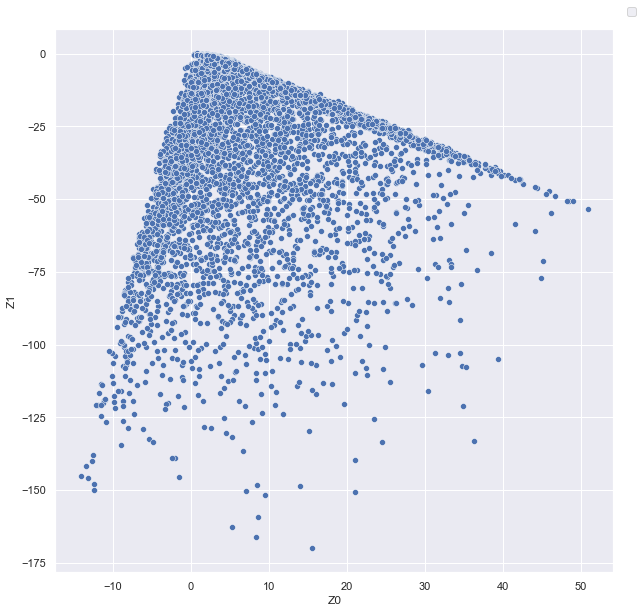

In [225]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='Z0',y='Z1',data=mu_tr_df)
plt.legend(bbox_to_anchor=(1.05, 1.05))

## Functions for Confidence Interval Estimation using CREDENCE

In [269]:
def gen_donor_samples(donor_normalized,vae_model,N,T,num_samples = 50):
    pi = vae_model.encode(donor_normalized)
    mu, logvar = pi
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    pi = mu, torch.log(torch.var(mu))*torch.ones_like(logvar)
    Z = vae_model.reparameterize(pi, eps) 
    S = train_arvae.generate_example_sample(vae_model, 0, 1, T, num_samples, N, latent_values=Z)
    return S

In [270]:
def credence_ci(y, vae_model, N, T0, num_samples = 50,noise=1,y_clean=[]):
    samples = []
    
    y_target = y[:,0]
    y_donors = y[:,1:]
    ypre_target = y[:T0,0]
    ypre_donors = y[:T0,1:]
    
    donor_mean = np.mean(y_donors)
    donor_std = np.std(y_donors)
    
    ypre_target_ = (ypre_target-donor_mean)/donor_std
    ypre_donor_ = (ypre_donors-donor_mean)/donor_std
    y_target_ = (y_target-donor_mean)/donor_std
    y_donor_ = (y_donors-donor_mean)/donor_std
    y_ = (y-donor_mean)/donor_std
    
#     print(f"\nMean of raw data: {np.mean(y_target_):.3f}")
#     print(f"Std. dev of raw data: {np.std(y_target_):.3f}")
    
    effect0, y_target_, y_target_lasso_ = synthetic_control( y_, T0 )
    
    effect = []
    
    T = y.shape[0]

    obs_data_norm = torch.tensor(y_donor_.reshape(1,-1)).float()*torch.ones(num_samples,N*T)
    S = gen_donor_samples(obs_data_norm,vae_model,N,T,num_samples = num_samples)
    for i in range(num_samples):
        Si = (S[:,i,:] - np.mean(S[:,i,:]))/np.std(S[:,i,:]) #gen_data(n_donor=N, T=T, T0=T0, noise=noise)[0][:,1:] #S[:T,i,:N]
#         if len(y_clean)!=0:
#             Si = y_clean[:,1:] + noise*np.random.normal(0,1,size=y_clean[:,1:].shape) #S[:T,i,:N]
        y_sample_ = np.hstack((y_target_.reshape(-1,1),Si))
        effect_i, y_target_sample, y_target_sample_lasso = synthetic_control( y_sample_, T0 )
        
        effect += [effect_i]
    
    effect = (np.array(effect).T) * donor_std
    return effect0*donor_std, effect

## Coverage Analysis

In [274]:
n_donor=10 
vae_model = vae_model
N = n_donor
T=30
T0=15
repeats = 50
num_samples = 50
np.random.seed(0)

y_clean,intervention,y1,y0 = gen_data( n_donor=n_donor, T=T, T0=T0, noise=0 )
coverage_dict = pd.DataFrame()
effect_df_pre = pd.DataFrame()
effect_df_post = pd.DataFrame()
for noise in tqdm.tqdm([1.0,2.0,3.0,4.0]):
    coverage = 0.0
    for repeat in (range(repeats)):
        y = y_clean + noise * np.random.normal(0,1,size=(y_clean.shape))
        y_target = y[:,0]
        y_donors = y[:,1:]
        ypre_target = y[:T0,0]
        ypre_donors = y[:T0,1:]
        effect0, effect = credence_ci(y, vae_model, N=N, T0=T0, num_samples=num_samples,noise=noise,y_clean=y_clean)
        effect_df_pre['%d_%.1f'%(repeat,noise)] = np.mean(effect[:T0,:],axis=0)
        effect_df_post['%d_%.1f'%(repeat,noise)] = np.mean(effect[T0:,:],axis=0)
        mean_effect = np.mean(effect_df_post['%d_%.1f'%(repeat,noise)])
        std_effect = np.sqrt(np.sum(np.cov(effect[T0:,:]))/(num_samples))
        if (0 <= mean_effect+2*std_effect) and (0 >= mean_effect-2*std_effect):
            coverage += 1
    coverage_dict[noise] = [coverage/repeats]

100%|██████████| 4/4 [23:14<00:00, 348.55s/it]


In [275]:
coverage_dict.to_csv('coverage_credence_resampling.csv')
effect_df_pre.to_csv('pre_intervention_effect_credence_resampling.csv')
effect_df_post.to_csv('post_intervention_effect_credence_resampling.csv')

In [276]:
coverage_dict

,1.0,2.0,3.0,4.0
0,0.94,0.84,0.88,0.86


In [201]:
donor_mean = np.mean(y_donors)
donor_std = np.std(y_donors)

ypre_target_ = (ypre_target-donor_mean)/donor_std
ypre_donor_ = (ypre_donors-donor_mean)/donor_std
y_target_ = (y_target-donor_mean)/donor_std
y_donor_ = (y_donors-donor_mean)/donor_std
y_ = (y-donor_mean)/donor_std

obs_data_norm = torch.tensor(y_donor_.reshape(1,-1)).float()*torch.ones(num_samples,N*T)
S = gen_donor_samples(torch.tensor(data_2d).float(),vae_model,N,T,num_samples = torch.tensor(data_2d).float().shape[0])


In [202]:
obs_data_norm.shape

torch.Size([50, 300])

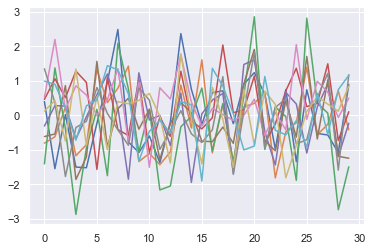

In [203]:
plt.plot(y_donor_)

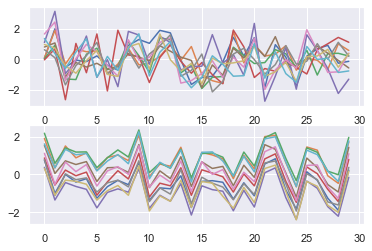

In [226]:
i = 20
fig,ax = plt.subplots(nrows=2)
ax[0].plot((data_[:,i,:]-np.mean(data_[:,i,:]))/np.std(data_[:,i,:]))
ax[1].plot((S[:,i,:]-np.mean(S[:,i,:]))/np.std(S[:,i,:]))

In [234]:
effect_df_post

,0_1.0,1_1.0,2_1.0,3_1.0,4_1.0,5_1.0,6_1.0,7_1.0,8_1.0,9_1.0,...,40_2.0,41_2.0,42_2.0,43_2.0,44_2.0,45_2.0,46_2.0,47_2.0,48_2.0,49_2.0
0,-0.071254,1.058725,0.229690,0.142749,0.654296,0.419185,0.142251,0.065524,0.30404,0.613897,...,0.769295,-0.183454,0.120773,0.42478,0.460522,0.849757,-0.103226,-0.945385,1.111569,1.033031
1,-0.071254,0.919829,0.229690,0.142749,0.654296,0.419185,0.142251,0.043415,0.30404,0.622709,...,0.769295,-0.144238,0.120773,0.42478,0.460522,0.647271,-0.716770,-3.034872,1.110685,2.090116
2,-4.414952,1.098778,0.229690,0.142749,0.654296,0.419185,0.142251,0.063961,0.30404,0.613201,...,0.769295,4.096085,0.120773,0.42478,0.460522,0.618107,0.141358,-0.945385,1.177003,1.910398
3,-0.071254,1.089507,0.229690,0.142749,0.654296,0.419185,0.142251,0.062084,0.30404,0.620000,...,0.690443,3.739999,0.120773,0.42478,0.460522,0.632175,0.220607,-0.945385,1.167268,1.821568
4,-4.042277,1.060211,0.229690,0.142749,0.654296,0.419185,0.142251,0.070100,0.30404,0.617377,...,0.769295,3.843300,0.120773,0.42478,0.460522,0.453524,0.953742,-0.945385,1.198525,1.986181
5,0.044825,1.151734,0.229690,0.142749,0.654296,0.419185,0.142251,0.044684,0.30404,0.606834,...,0.769295,4.079242,0.120773,0.42478,0.363193,0.734862,0.642737,-0.945385,1.189733,1.736703
6,-0.071254,1.069389,0.229690,0.142749,0.654296,0.419185,0.142251,0.058721,0.30404,0.616500,...,0.769295,4.074864,0.120773,0.42478,0.528442,0.609950,0.003945,-0.945385,1.183813,1.419350
7,-0.071254,1.229052,0.229690,0.142749,0.654296,0.419185,0.142251,0.070839,0.30404,0.611140,...,0.769295,0.057424,0.120773,0.42478,0.460522,0.486115,0.244807,-0.945385,1.148535,2.011617
8,-0.071254,1.216729,0.229690,0.142749,0.654296,0.419185,0.142251,0.049757,0.30404,0.616878,...,-0.585035,3.645020,0.120773,0.42478,0.460522,0.807634,1.005966,-0.945385,1.186630,1.747135
9,-0.071254,1.028266,0.229690,0.142749,0.654296,0.419185,0.142251,0.071828,0.30404,0.615209,...,0.769295,4.056838,0.120773,0.42478,0.460522,0.612278,-0.345044,-3.423211,1.099612,1.944386


In [259]:
torch.var(mu_tr,axis=1)

tensor([[ 64.6273, 651.7206]], grad_fn=<VarBackward1>)

In [261]:
torch.log(torch.var(mu_tr,axis=1))*torch.ones_like(logvar_tr)

tensor([[[4.1686, 6.4796],
         [4.1686, 6.4796],
         [4.1686, 6.4796],
         ...,
         [4.1686, 6.4796],
         [4.1686, 6.4796],
         [4.1686, 6.4796]]], grad_fn=<MulBackward0>)

In [262]:
np.log(651.7206)

6.479615942475096